# Beam Training using Fully Connected Neural Networks
The first section loads the data, while the next two sections run FC NNs for beam training via classification and regression.

This notebook is built to run with the real data (pRx data from the TG sounders)

## THIS NOTEBOOK SAVES RESULTS FOR THE FIRST SET OF EXPERIMENTAL RESULTS
- Note: run the first load data cell with NUM_ANGLES_PER_DFT=20 before changing this value.  This initializes some variables for general use.

## Modifiable notebook (used for analysis on the training set size)
- SAME_DATA flag - use for analysis of the number of training points used (forces the test to use the same set of points each time and the training to always pick the first points)
                 - Doesn't seem to make a huge difference to performance -> perhaps more consistent but not dramatically better (still some stochastic nature in the training)
- Tested with N=7, SAME_DATA=1, and varied num training points per label/snr -> does show improvement for a larger number of training points


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

print(tf.__version__)

2.1.0


# Load data
Load data for a given SNR.  Repeat this cell for every SNR run.

Processing date: 20-04-16, TXIDX: 21, SNR: 21, Type: ext
	DFT data:  (1787, 64)
	PN data:   (1787, 36)
	Labels:    (1787, 1)
Processing date: 20-04-15, TXIDX: 15, SNR: 15, Type: ext
	DFT data:  (1722, 64)
	PN data:   (1722, 36)
	Labels:    (1722, 1)
Processing date: 20-04-20, TXIDX: 12, SNR: 12, Type: ext
	DFT data:  (1728, 64)
	PN data:   (1728, 36)
	Labels:    (1728, 1)
Num DFT beams to use:  51
Num samples to use:    4958
Num PN beam combos:    1
	NOT USING RANDOM BEAMS -> FIRST 36 PN MEASUREMENTS USED!


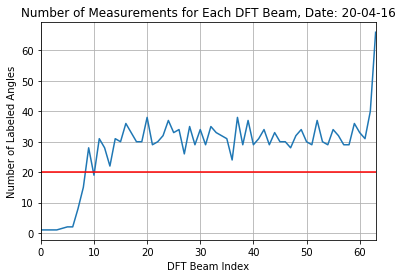

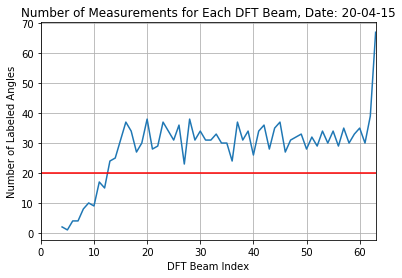

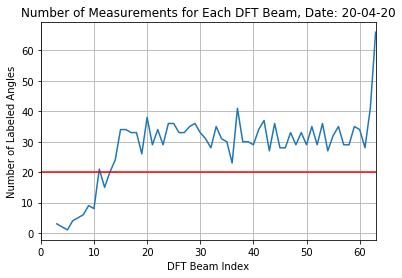

In [2]:
### Load Experimental Data ###
## Dataset Constants
DATA_DATES = ["20-04-16", "20-04-15", "20-04-20"]
DATA_TXIDX = [21, 15, 12]
DATA_SNR = [21, 15, 12] #TODO: FIX THIS NUMBER
# DATA_DATES = ["20-04-15"]
# DATA_TXIDX = [15]
# DATA_SNR = [15] #TODO: FIX THIS NUMBER
NUM_DFT = 64                # Number of DFT beams measured
NUM_ANGLES_PER_DFT = 20     # Number of measurements to use for a DFT (per each date; minimum required to be included)
NUM_TOTAL_MEAS = 36         # Number of total PN beam/measurements/features collected (in a file)
NUM_MEAS = 36               # Number of PN beams/measurements/features to use (5, 10, 15 typically) #TODO: NEED TO CHOOSE THE ANGLES SOMEHOW
NUM_PN_COMBO = 1           # Number of random combinations of measurements to run with the algorithm (to ensure the results aren't dependent on beam)(limit NUM_TOTAL_MEAS choose NUM_MEAS)
                            # Set the NUM_PN_COMBO to 1 for the first NUM_MEAS PN beams (i.e. NOT random)

SAME_DATA = 0               # Use the same data for all tests (based on test data for MAX_NUM_ANGLES_PER_DFT) and non-randomized training data
MAX_NUM_ANGLES_PER_DFT = 20 # Max number of points per DFT label required (typically 20)
DATA_LINEAR_SCALE = True   # Rescale the data from log to linear (pRx is in dB)
DATA_ZERO_MEAN = False      # Offset the data by the mean features of the training data (same offset used for test data)
DATA_NORMALIZATION = True  # Scale the data (training and testing) to the maximum norm of the training data
DATA_TYPE = "ext"          # Qualifier for the data type ("ext" = normalized_extended OR "avg" = normalized)

DATA_DFT_FILESTEM = "../data/results_awv0_{}_{}_dft.csv"
DATA_PN_FILESTEM = "../data/results_awv0_{}_{}_pn.csv"
DATA_LABELS_FILESTEM = "../data/results_awv0_{}_{}_labels.csv"

DATA_STFSNR_DFT_FILESTEM = "../data/results_awv0_{}_{}_stfsnr_dft.csv"
DATA_STFSNR_PN_FILESTEM = "../data/results_awv0_{}_{}_stfsnr_pn.csv"

## Computed Constants
NUM_DATES = len(DATA_DATES)
max_pn_combos = comb(NUM_TOTAL_MEAS, NUM_MEAS)
if (NUM_PN_COMBO > max_pn_combos):
    NUM_PN_COMBO = max_pn_combos.astype(int)

# Compute the PN beams to use for each PN combo set (number of combos = NUM_PN_COMBO)
PN_USE_BEAMS = np.zeros((NUM_PN_COMBO, NUM_MEAS))
if NUM_PN_COMBO > 1:
    # Using more than 1 combo -> randomly choose the combinations of beams
    for pn_i in np.arange(NUM_PN_COMBO):
        PN_USE_BEAMS[pn_i, :] = np.random.choice(NUM_TOTAL_MEAS, NUM_MEAS, replace=False)
elif NUM_PN_COMBO == 1:
    # Using only 1 combo -> Use the first NUM_MEAS beams
    PN_USE_BEAMS[0, :] = np.arange(NUM_MEAS)
else:
    # Invalid number of combos -> error out
    print("INVALID NUMBER OF PN MEASUREMENTS {} -- RERUN WITH A NEW NUMBER".format(NUM_PN_COMBO))
    
PN_USE_BEAMS = PN_USE_BEAMS.astype(int)

## Loop through each test date and determine the data to use
dft_use_all = np.zeros((NUM_DATES, NUM_DFT))
dft_use_all_num = np.zeros((NUM_DATES, NUM_DFT))
for date_i in np.arange(NUM_DATES):

    ## Get the file names
    print("Processing date: {}, TXIDX: {}, SNR: {}, Type: {}".format(DATA_DATES[date_i], DATA_TXIDX[date_i], DATA_SNR[date_i], DATA_TYPE))
    dft_file = DATA_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    pn_file = DATA_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    labels_file = DATA_LABELS_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    SNR_i = DATA_SNR[date_i]

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)

    ## Pickout the data to use
    u, c = np.unique(df_labels, return_counts=True)
    plt.figure()
    plt.plot(u, c)
    plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(DATA_DATES[date_i]))
    plt.xlabel("DFT Beam Index")
    plt.ylabel("Number of Labeled Angles")
    plt.grid(True)
    plt.xlim(0, 63)
    plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

    # Pick the DFT indices just based on meeting the minimum number of angles required
    dft_valid_mask = u[c >= NUM_ANGLES_PER_DFT].astype(int)
    dft_use_all[date_i, dft_valid_mask] = True
    dft_use_all_num[date_i, dft_valid_mask] = c[c >= NUM_ANGLES_PER_DFT]
    
if NUM_ANGLES_PER_DFT == MAX_NUM_ANGLES_PER_DFT:
    pick_dft = np.all(dft_use_all, 0)
    dft_use = np.nonzero(pick_dft)[0]
    dft_use_num = dft_use_all_num[:,pick_dft].astype(int)
    NUM_CLASSES = len(dft_use)

print("Num DFT beams to use: ", NUM_CLASSES)
print("Num samples to use:   ", np.sum(dft_use_num))
print("Num PN beam combos:   ", NUM_PN_COMBO)
if NUM_PN_COMBO == 1:
    print("\tNOT USING RANDOM BEAMS -> FIRST {} PN MEASUREMENTS USED!".format(NUM_MEAS))

In [3]:
# Running dictonaries for the data
train_data_dict = {}
test_data_dict = {}
#val_data_dict = {}
train_labels_dict = {}
test_labels_dict = {}
#val_labels_dict = {}
train_classes_dict = {}
test_classes_dict = {}
dft_rssi_dict = {}

# The actual loop
for date_i in np.arange(NUM_DATES):

    ## Get the file names
    print("Processing date: {}, TXIDX: {}, SNR: {}, Type: {}".format(DATA_DATES[date_i], DATA_TXIDX[date_i], DATA_SNR[date_i], DATA_TYPE))
    dft_file = DATA_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    pn_file = DATA_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    labels_file = DATA_LABELS_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    stfsnr_dft_file = DATA_STFSNR_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    stfsnr_pn_file = DATA_STFSNR_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    SNR_i = DATA_SNR[date_i]

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_stfsnr_dft = pd.read_csv(stfsnr_dft_file, header=None)
    df_stfsnr_pn = pd.read_csv(stfsnr_pn_file, header=None)
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)
    arr_pn = df_pn.to_numpy()
    arr_dft = df_dft.to_numpy()
    arr_stfsnr_dft = df_stfsnr_dft.to_numpy()
    arr_stfsnr_pn = df_stfsnr_pn.to_numpy()

#     ## Pickout the data to use
#     u, c = np.unique(df_labels, return_counts=True)
#     plt.figure()
#     plt.plot(u, c)
#     plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(DATA_DATES[date_i]))
#     plt.xlabel("DFT Beam Index")
#     plt.ylabel("Number of Labeled Angles")
#     plt.grid(True)
#     plt.xlim(0, 63)
#     plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

#     # Pick the DFT indices just based on meeting the minimum number of angles required
#     dft_use = u[c >= NUM_ANGLES_PER_DFT].astype(int)
#     dft_use_num = c[c >= NUM_ANGLES_PER_DFT]
    
    # Running dictionary for the data for each PN beam combo
    train_data_datei_dict = {}
    test_data_datei_dict = {}
    #val_data_datei_dict = {}
    train_labels_datei_dict = {}
    test_labels_datei_dict = {}
    #val_labels_datei_dict = {}
    train_classes_datei_dict = {}
    test_classes_datei_dict = {}
    dft_rssi_datei_dict = {}
    
    # Loop through all the PN beam combos
    for pn_i in np.arange(NUM_PN_COMBO):

        # Choose the points randomly from the points available (per each used DFT beam)
        train_data = np.array([])
        train_labels = np.array([])
        test_data = np.array([])
        test_labels = np.array([])
        train_classes = np.array([])
        test_classes = np.array([])
        test_dftrssi = np.array([])
        
        for dft_i in np.arange(len(dft_use)):

            # Find all potential PN beam measurements to use for this DFT beam label
            wh = np.where(df_labels == dft_use[dft_i])
            pn_all_i_temp = arr_pn[wh[0], :]
            pn_all_i = pn_all_i_temp[:,PN_USE_BEAMS[pn_i]]
            dft_all_i = arr_dft[wh[0], :]
            #print("------ PN select size: {}".format(pn_all_i.shape))
#             print(dft_use[dft_i])
#             print(len(wh[0]))
#             print(pn_all_i.shape)

            # Randomly pick the indices to include
            pn_all_ind = np.arange(dft_use_num[date_i, dft_i])
            if not SAME_DATA:
                pn_choice_ind = np.random.choice(pn_all_ind, NUM_ANGLES_PER_DFT, replace=False)
                pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_ind)
            else:
                pn_choice_max_ind = np.arange(MAX_NUM_ANGLES_PER_DFT)
                pn_choice_ind = np.arange(NUM_ANGLES_PER_DFT)
                pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_max_ind)
                
            pn_choice = pn_all_i[pn_choice_ind, :]
            pn_nchoice = pn_all_i[pn_nchoice_ind, :]
            dft_nchoice = dft_all_i[pn_nchoice_ind, :]
                
            choice_labels = dft_use[dft_i] * np.ones((NUM_ANGLES_PER_DFT, 1))
            choice_classes = dft_i * np.ones((NUM_ANGLES_PER_DFT, 1))
            if not SAME_DATA:
                nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[date_i, dft_i] - NUM_ANGLES_PER_DFT, 1))
                nchoice_classes = dft_i * np.ones((dft_use_num[date_i, dft_i] - NUM_ANGLES_PER_DFT, 1))
            else:
                nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[date_i, dft_i] - MAX_NUM_ANGLES_PER_DFT, 1))
                nchoice_classes = dft_i * np.ones((dft_use_num[date_i, dft_i] - MAX_NUM_ANGLES_PER_DFT, 1))
            
            if dft_i == 0:
                train_data = pn_choice
                train_labels = choice_labels
                test_data = pn_nchoice
                test_labels = nchoice_labels
                train_classes = choice_classes
                test_classes = nchoice_classes
                test_dftrssi = dft_nchoice
            else:
                train_data = np.vstack((train_data, pn_choice))
                train_labels = np.vstack((train_labels, choice_labels))
                test_data = np.vstack((test_data, pn_nchoice))
                test_labels = np.vstack((test_labels, nchoice_labels))
                train_classes = np.vstack((train_classes, choice_classes))
                test_classes = np.vstack((test_classes, nchoice_classes))
                test_dftrssi = np.vstack((test_dftrssi, dft_nchoice))
        
        # Store the results in the date dictionary
        print("\t\tTraining data: {}; labels: {}; classes: {} - PN combo {}".format(train_data.shape, train_labels.shape, train_classes.shape, pn_i))
        print("\t\tTesting data:  {}; labels: {}; classes: {} - PN combo {}".format(test_data.shape, test_labels.shape, test_classes.shape, pn_i))
        train_data_datei_dict[pn_i] = train_data
        test_data_datei_dict[pn_i] = test_data
        #val_data_datei_dict[pn_i] = val_data
        train_labels_datei_dict[pn_i] = train_labels.astype(int)
        test_labels_datei_dict[pn_i] = test_labels.astype(int)
        #val_labels_datei_dict[pn_i] = val_labels
        train_classes_datei_dict[pn_i] = train_classes.astype(int)
        test_classes_datei_dict[pn_i] = test_classes.astype(int)
        
        # Save the DFT beam RSSI for future gain loss performance evaluation
        dft_rssi_datei_dict[pn_i] = test_dftrssi
        
    # Store the results in the overall dictionaries
    print("\tTraining dictionaries - data: {}; labels: {}; classes: {}".format(len(train_data_datei_dict), len(train_labels_datei_dict), len(train_classes_datei_dict)))
    print("\tTesting dictionaries - data:  {}; labels: {}; classes: {}".format(len(test_data_datei_dict), len(test_labels_datei_dict), len(test_classes_datei_dict)))
    train_data_dict[SNR_i] = train_data_datei_dict
    test_data_dict[SNR_i] = test_data_datei_dict
    #val_data_dict[SNR_i] = val_data_datei_dict
    train_labels_dict[SNR_i] = train_labels_datei_dict
    test_labels_dict[SNR_i] = test_labels_datei_dict
    #val_labels_dict[SNR_i] = val_labels_datei_dict
    train_classes_dict[SNR_i] = train_classes_datei_dict
    test_classes_dict[SNR_i] = test_classes_datei_dict
    dft_rssi_dict[SNR_i] = dft_rssi_datei_dict
    
## Final variable cleanup
train_data_all = {}
train_labels_all = {}
train_classes_all = {}
# val_data_all = {}
# val_labels_all = {}
# val_classes_all = {}
test_data_all = {}
test_labels_all = {}
test_classes_all = {}
test_dftrssi_all = {}

print("\nCreating total training/validation/test datasets:")
for pn_i in np.arange(NUM_PN_COMBO):
    # Running variables
    train_data_pni = np.array([])
    train_labels_pni = np.array([])
    train_classes_pni = np.array([])
    # val_data_pni = np.array([])
    # val_labels_pni = np.array([])
    # val_classes_pni = np.array([])
    test_data_pni = np.array([])
    test_labels_pni = np.array([])
    test_classes_pni = np.array([])
    test_dftrssi_pni = np.array([])
    importeddata = False
    
    # Combine the data for each set of PN beams/measurements
    for snr_i in np.arange(len(train_data_dict)):
        #print("\ttrain: {}, val: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape, val_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        print("\ttrain: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        if not importeddata:
            train_data_pni = train_data_dict[DATA_SNR[snr_i]][pn_i]
            train_labels_pni = train_labels_dict[DATA_SNR[snr_i]][pn_i]
            train_classes_pni = train_classes_dict[DATA_SNR[snr_i]][pn_i]
    #         val_data_pni = val_data_dict[DATA_SNR[snr_i]][pn_i]
    #         val_labels_pni = val_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_data_pni = test_data_dict[DATA_SNR[snr_i]][pn_i]
            test_labels_pni = test_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_classes_pni = test_classes_dict[DATA_SNR[snr_i]][pn_i]
            test_dftrssi_pni = dft_rssi_dict[DATA_SNR[snr_i]][pn_i]
            importeddata = True
        else:
            train_data_pni = np.vstack((train_data_pni, train_data_dict[DATA_SNR[snr_i]][pn_i]))
            train_labels_pni = np.vstack((train_labels_pni, train_labels_dict[DATA_SNR[snr_i]][pn_i]))
            train_classes_pni = np.vstack((train_classes_pni, train_classes_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_data_pni = np.vstack((val_data_pni, val_data_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_labels_pni = np.vstack((val_labels_pni, val_labels_dict[DATA_SNRR[snr_i]][pn_i]))
            test_data_pni = np.vstack((test_data_pni, test_data_dict[DATA_SNR[snr_i]][pn_i]))
            test_labels_pni = np.vstack((test_labels_pni, test_labels_dict[DATA_SNR[snr_i]][pn_i]))
            test_classes_pni = np.vstack((test_classes_pni, test_classes_dict[DATA_SNR[snr_i]][pn_i]))
            test_dftrssi_pni = np.vstack((test_dftrssi_pni, dft_rssi_dict[DATA_SNR[snr_i]][pn_i]))
    
    # Store the combined data for this set of features into the overall dictionary
    train_data_all[pn_i] = train_data_pni
    train_labels_all[pn_i] = train_labels_pni
    train_classes_all[pn_i] = train_classes_pni
    test_data_all[pn_i] = test_data_pni
    test_labels_all[pn_i] = test_labels_pni
    test_classes_all[pn_i] = test_classes_pni
    test_dftrssi_all[pn_i] = test_dftrssi_pni

## Data scaling and normalization
print("\nRunning data scaling and normalization...")
NUM_TRAIN = np.zeros((NUM_PN_COMBO, 1))
for pn_i in np.arange(NUM_PN_COMBO):
    print("\tTraining data range: ({}, {}) --- PN set {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i]), pn_i))
    if DATA_LINEAR_SCALE:
        print("\t\tUsing linear scale data...")
        train_data_all[pn_i] = 10**(train_data_all[pn_i]/10)
        test_data_all[pn_i] = 10**(test_data_all[pn_i]/10)
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = 10**(test_data_dict[DATA_SNR[snr_i]][pn_i]/10)

    if DATA_ZERO_MEAN:
        train_mean = np.mean(train_data_all[pn_i], 0)
        print("\t\tUsing zero-mean offset; offset by {}...".format(train_mean))
        train_data_all[pn_i] = train_data_all[pn_i] - train_mean
        test_data_all[pn_i] = test_data_all[pn_i] - train_mean
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i] - train_mean

    if DATA_NORMALIZATION:
        data_scale = np.max(np.linalg.norm(train_data_all[pn_i], 2, 1))
        print("\t\tData scale factor (max norm): {}...".format(data_scale))
        train_data_all[pn_i] = train_data_all[pn_i]/data_scale
        test_data_all[pn_i] = test_data_all[pn_i]/data_scale
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i]/data_scale
        print("\t\tNew training data range: {}, {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i])))

    NUM_TRAIN[pn_i] = int(train_data_all[pn_i].shape[0])
    print("\t\tTotal training dataset size (PN set {}): {}".format(pn_i, train_data_all[pn_i].shape))
    print("\t\tTotal test dataset size     (PN set {}): {}".format(pn_i, test_data_all[pn_i].shape))
    # NUM_VAL = int(val_data_all.shape[0])
    # print("Total validation dataset size: {}".format(val_data_all.shape))
    
# Save the total test data to a new dictionary key (useful for test loops)
test_data_dict['ALL'] = test_data_all
test_labels_dict['ALL'] = test_labels_all
test_classes_dict['ALL'] = test_classes_all
dft_rssi_dict['ALL'] = test_dftrssi_all

Processing date: 20-04-16, TXIDX: 21, SNR: 21, Type: ext
	DFT data:  (1787, 64)
	PN data:   (1787, 36)
	Labels:    (1787, 1)
		Training data: (1020, 36); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (632, 36); labels: (632, 1); classes: (632, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Processing date: 20-04-15, TXIDX: 15, SNR: 15, Type: ext
	DFT data:  (1722, 64)
	PN data:   (1722, 36)
	Labels:    (1722, 1)
		Training data: (1020, 36); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (632, 36); labels: (632, 1); classes: (632, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Processing date: 20-04-20, TXIDX: 12, SNR: 12, Type: ext
	DFT data:  (1728, 64)
	PN data:   (1728, 36)
	Labels:    (1728, 1)
		Training data: (1020, 36); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testi

Processing date: 20-04-16, TXIDX: 21, SNR: 21, Type: ext
(1652,)
(1652, 36)
	STF-SNR (DFT labels): SNR 21
		Mean: 22.14225181598063; Std-dev: 3.268231673356274
		Percentiles:
[[  0.  -7.]
 [ 10.  22.]
 [ 20.  22.]
 [ 30.  22.]
 [ 40.  22.]
 [ 50.  23.]
 [ 60.  23.]
 [ 70.  23.]
 [ 80.  23.]
 [ 90.  23.]
 [100.  25.]]
	STF-SNR (PN beams): SNR 21
		Mean: 6.724963007801991; Std-dev: 19.060282282961904
		Percentiles:
[[   0. -100.]
 [  10.    2.]
 [  20.    5.]
 [  30.    7.]
 [  40.    9.]
 [  50.   10.]
 [  60.   12.]
 [  70.   13.]
 [  80.   14.]
 [  90.   15.]
 [ 100.   21.]]



Processing date: 20-04-15, TXIDX: 15, SNR: 15, Type: ext
(1652,)
(1652, 36)
	STF-SNR (DFT labels): SNR 15
		Mean: 23.081113801452783; Std-dev: 2.460724261801439
		Percentiles:
[[  0.  -7.]
 [ 10.  22.]
 [ 20.  23.]
 [ 30.  23.]
 [ 40.  23.]
 [ 50.  23.]
 [ 60.  24.]
 [ 70.  24.]
 [ 80.  24.]
 [ 90.  24.]
 [100.  25.]]
	STF-SNR (PN beams): SNR 15
		Mean: 9.69306564433683; Std-dev: 15.208393020254876
		Percentile

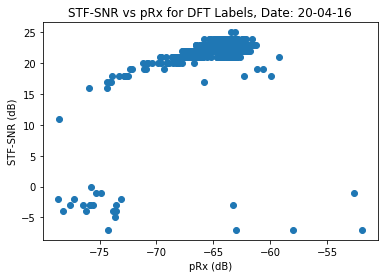

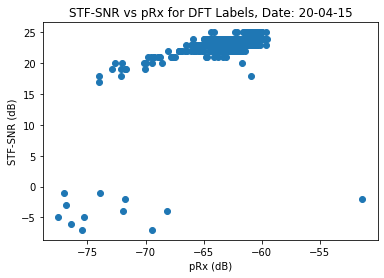

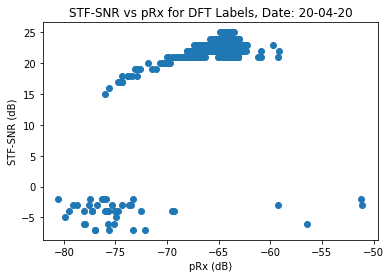

In [57]:
## Compute statistics on the DFT label beam and PN beam STF-SNR
STFSNR_PERCENTILES = np.arange(0, 110, 10)
stfsnr_dft_dict = {} # Store the STF-SNR for the label DFT beams by beam label
stfsnr_pn_dict = {}  # Store the STF-SNR for the selected PN beams by beam label

for date_i in np.arange(NUM_DATES):

    ## Get the file names
    print("Processing date: {}, TXIDX: {}, SNR: {}, Type: {}".format(DATA_DATES[date_i], DATA_TXIDX[date_i], DATA_SNR[date_i], DATA_TYPE))
    dft_file = DATA_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    labels_file = DATA_LABELS_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    stfsnr_dft_file = DATA_STFSNR_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    stfsnr_pn_file = DATA_STFSNR_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    SNR_i = DATA_SNR[date_i]

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_stfsnr_dft = pd.read_csv(stfsnr_dft_file, header=None)
    df_stfsnr_pn = pd.read_csv(stfsnr_pn_file, header=None)
    
    arr_dft = df_dft.to_numpy()
    arr_stfsnr_dft = df_stfsnr_dft.to_numpy()
    arr_stfsnr_pn = df_stfsnr_pn.to_numpy()
    
    # Running dictionaries for the data for each PN beam combo
    stfsnr_dft_arr_i = {}
    stfsnr_pn_arr_i = {}
    stfsnr_dft_date_i = np.array([])
    sftsnr_pn_date_i = np.array([])
    prx_dft_date_i = np.array([])
    
    # Loop through all the DFT beam labels (to determine which points are actually used)
    pn_combo_i = 0
    for dft_i in np.arange(len(dft_use)):

        # Find all potential PN beam measurements to use for this DFT beam label
        wh = np.where(df_labels == dft_use[dft_i])
        dft_all_i = arr_dft[wh[0], :]
        pn_ss_i_temp = arr_stfsnr_pn[wh[0], :]
        stfsnr_pn_arr_i[dft_use[dft_i]] = pn_ss_i_temp[:,PN_USE_BEAMS[pn_combo_i]]
        stfsnr_dft_arr_i[dft_use[dft_i]] = arr_stfsnr_dft[wh[0], dft_use[dft_i]]
        
        #print(stfsnr_dft_arr_i[dft_use[dft_i]].shape)
        # Add to the overall lists of data
        if dft_i == 0:
            stfsnr_pn_date_i = stfsnr_pn_arr_i[dft_use[dft_i]]
            stfsnr_dft_date_i = stfsnr_dft_arr_i[dft_use[dft_i]]
            prx_dft_date_i = dft_all_i[:, dft_use[dft_i]]
        else:
            stfsnr_pn_date_i = np.vstack((stfsnr_pn_date_i, stfsnr_pn_arr_i[dft_use[dft_i]]))
            stfsnr_dft_date_i = np.concatenate((stfsnr_dft_date_i, stfsnr_dft_arr_i[dft_use[dft_i]]))
            prx_dft_date_i = np.concatenate((prx_dft_date_i, dft_all_i[:, dft_use[dft_i]]))
        
        #print("dft {} -> {}".format(stfsnr_dft_arr_i[dft_use[dft_i]].shape, stfsnr_dft_date_i.shape))
        #print("pn  {} -> {}".format(stfsnr_pn_arr_i[dft_use[dft_i]].shape, stfsnr_pn_date_i.shape))
        
    stfsnr_dft_dict[date_i] = stfsnr_dft_arr_i
    stfsnr_pn_dict[date_i] = stfsnr_pn_arr_i
    print(stfsnr_dft_date_i.shape)
    print(stfsnr_pn_date_i.shape)
    
    # Compute the statistics for this day's data
    stfsnr_dft_perc_i = np.percentile(stfsnr_dft_date_i, STFSNR_PERCENTILES, interpolation='lower')
    print("\tSTF-SNR (DFT labels): SNR {}".format(SNR_i))
    print("\t\tMean: {}; Std-dev: {}".format(np.mean(stfsnr_dft_date_i), np.std(stfsnr_dft_date_i)))
    print("\t\tPercentiles:")
    print(np.vstack((STFSNR_PERCENTILES, stfsnr_dft_perc_i)).T)

    stfsnr_pn_perc_i = np.percentile(stfsnr_pn_date_i, STFSNR_PERCENTILES, interpolation='lower')
    print("\tSTF-SNR (PN beams): SNR {}".format(SNR_i))
    print("\t\tMean: {}; Std-dev: {}".format(np.mean(stfsnr_pn_date_i), np.std(stfsnr_pn_date_i)))
    print("\t\tPercentiles:")
    print(np.vstack((STFSNR_PERCENTILES, stfsnr_pn_perc_i)).T)
    
    # Plot STF-SNR vs. pRx (DFT labels only)\
    plt.figure()
    plt.scatter(prx_dft_date_i, stfsnr_dft_date_i)
    plt.title("STF-SNR vs pRx for DFT Labels, Date: {}".format(DATA_DATES[date_i]))
    plt.xlabel("pRx (dB)")
    plt.ylabel("STF-SNR (dB)")
    
    print("\n\n")
        
## Compute the statistics - over all beams as well as individually
# print("Computing statistics...")
# for date_i in np.arange(NUM_DATES):
#     stfsnr_dft_date_i = np.array([])
#     sftsnr_pn_date_i = np.array([])
    
#     for dft_i in np.arange(len(dft_use)):


In [45]:
## Compute the percentiles of the RSSI values (only for debugging)
lab = test_labels_all[0].flatten()
max_gain = dft_rssi_dict["ALL"][0][np.arange(len(lab)), lab]
print(test_labels_all[0].shape)
print(max_gain.shape)
print(np.vstack((STFSNR_PERCENTILES, np.percentile(max_gain, STFSNR_PERCENTILES, interpolation='lower'))).T)

negind = (max_gain == -100)
negrows = dft_rssi_dict["ALL"][0][negind, :]
for i in np.arange(np.sum(negind)):
    print(negrows[i,:])
    

(1898, 1)
(1898,)
[[  0.       -80.540993]
 [ 10.       -66.576306]
 [ 20.       -65.367753]
 [ 30.       -64.746709]
 [ 40.       -64.292655]
 [ 50.       -64.013817]
 [ 60.       -63.454726]
 [ 70.       -62.897016]
 [ 80.       -62.33953 ]
 [ 90.       -61.570088]
 [100.       -52.657437]]


# Classification Method - Only Discrete Beams Considered
Beam training can be thought of as a classification problem; optimize for the best training beam/code quickly (one shot or a few shots).  Compressive sensing methods are able to reduce the number of training beams required to predict the AoA, but ML methods might improve on this.

In [106]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
all_test_acc = {}
all_confusionMat = {}
all_RMSE_disc = {}
all_RMSE_cont = {}
all_pe_byLabel = {}
all_gainLoss = {}
GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)

data_scale = 1

# Custom loss function
def cLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))


In [10]:
### Dictionaries to hold metrics for different runs ###
# Keys: Number of features used to train
class_test_acc = {}
class_confusionMat = {}
class_RMSE_disc = {}
class_RMSE_cont = {}


### NN for 36 measurements (i.e. all PN beams measured)


Training model for PN combo 0...
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 36)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
batch_normalization_40 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 18,035
Trainable params: 17,651
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

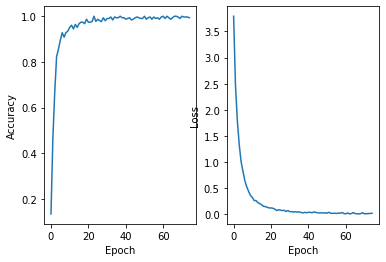

In [107]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.5686 - sparse_categorical_accuracy: 0.8645
	Test accuracy: 0.86451614


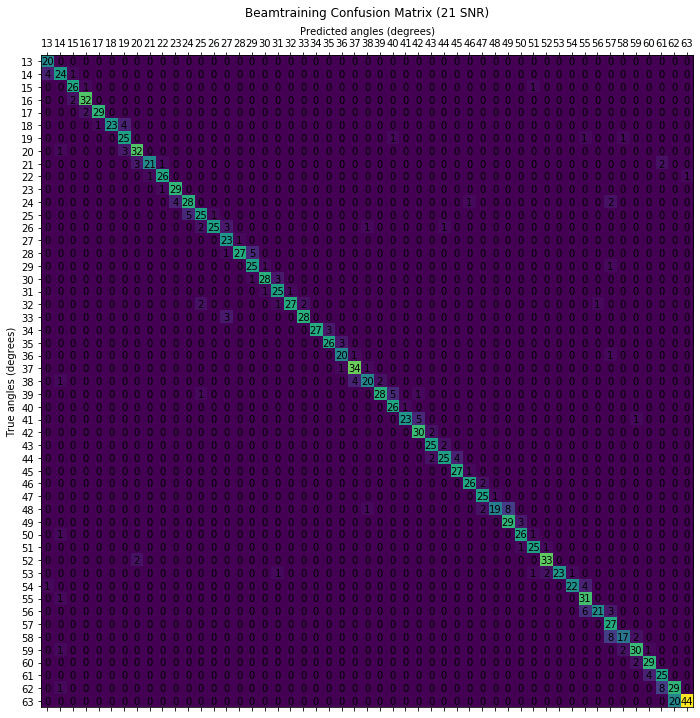

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6005 - sparse_categorical_accuracy: 0.8574
	Test accuracy: 0.8574194


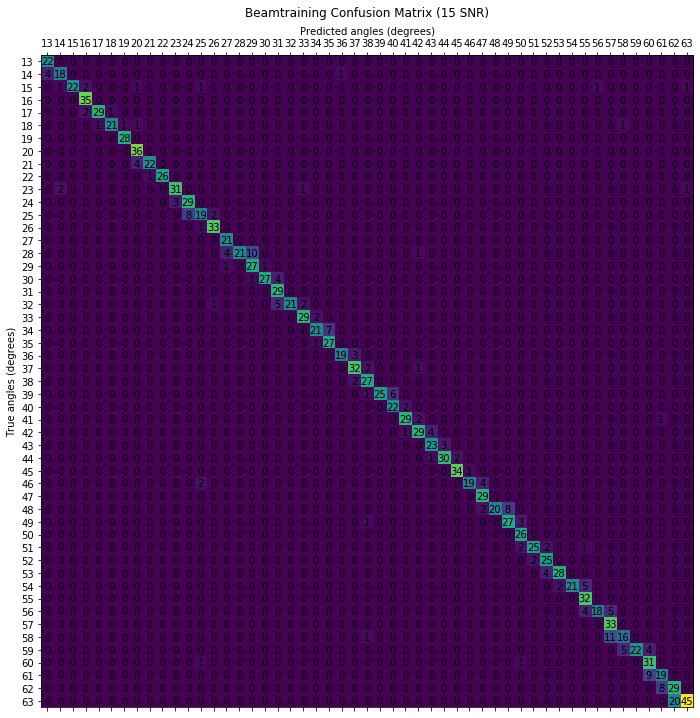

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.6400 - sparse_categorical_accuracy: 0.8550
	Test accuracy: 0.85502577


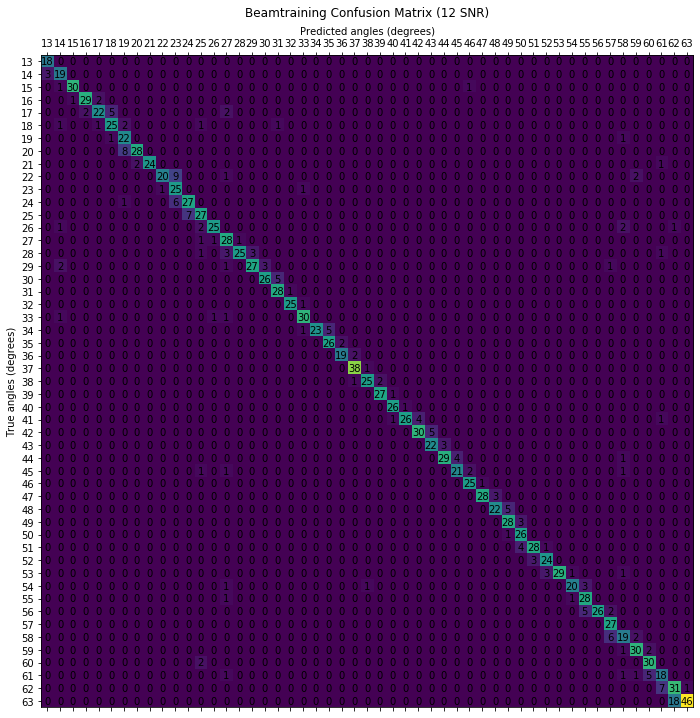

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.6030 - sparse_categorical_accuracy: 0.8590
	Test accuracy: 0.85898536


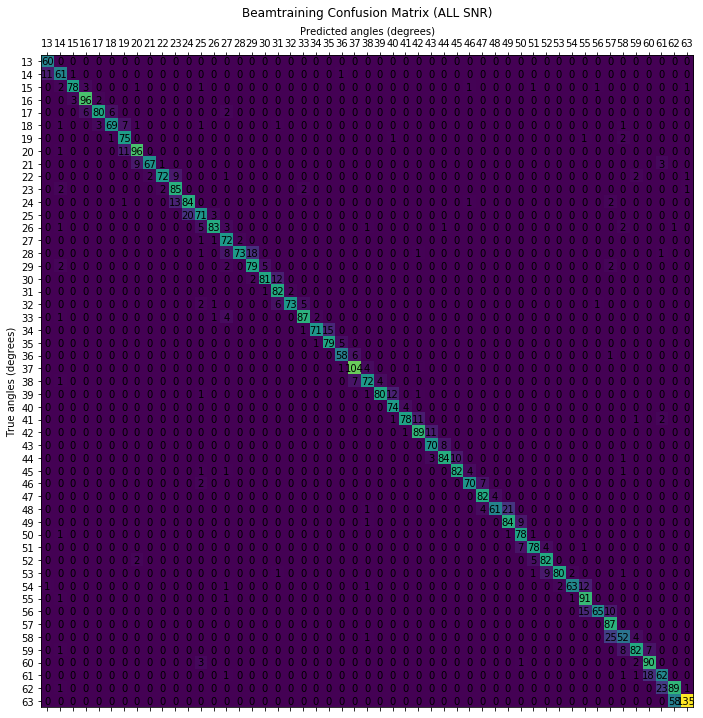


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.257879]
 [100.        37.421115]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.474949]
 [100.        38.728165]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

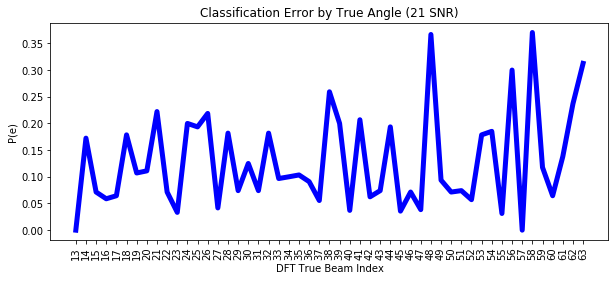

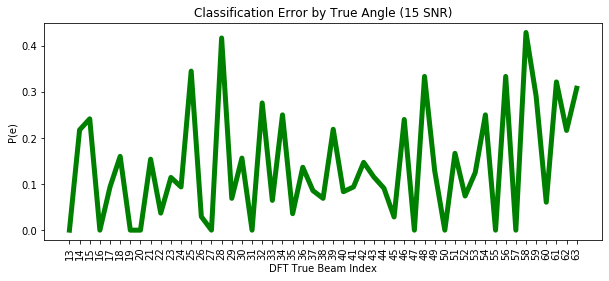

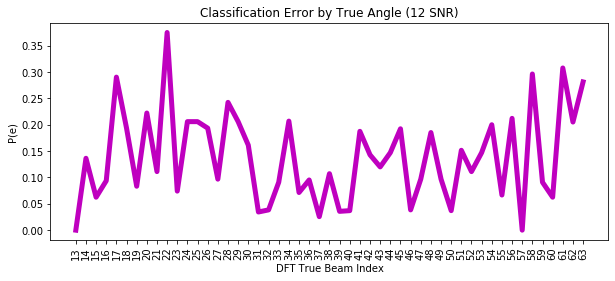

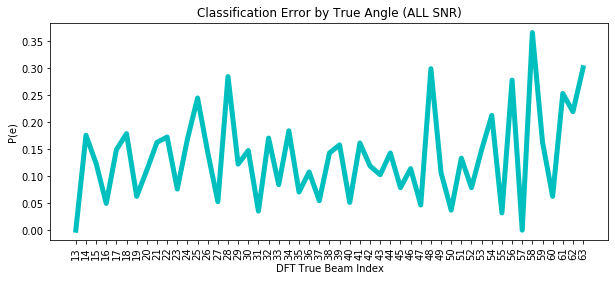

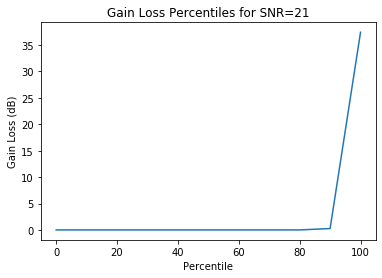

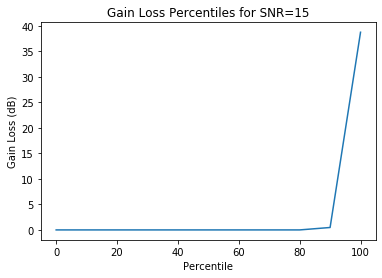

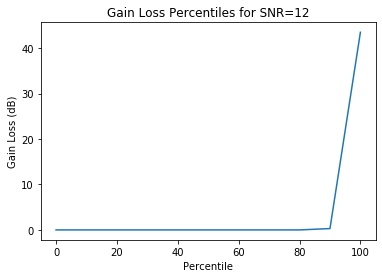

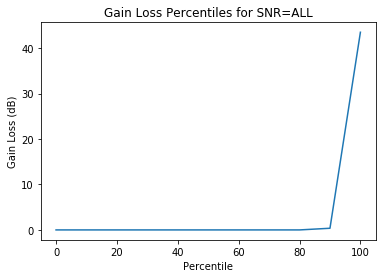

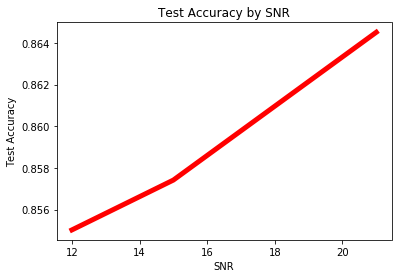

In [108]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 20 Measurements


Training model for PN combo 0...
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
batch_normalization_42 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_43 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 17,011
Trainable params: 16,627
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

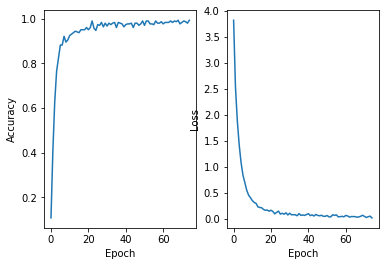

In [111]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6802 - sparse_categorical_accuracy: 0.8555
	Test accuracy: 0.8554839


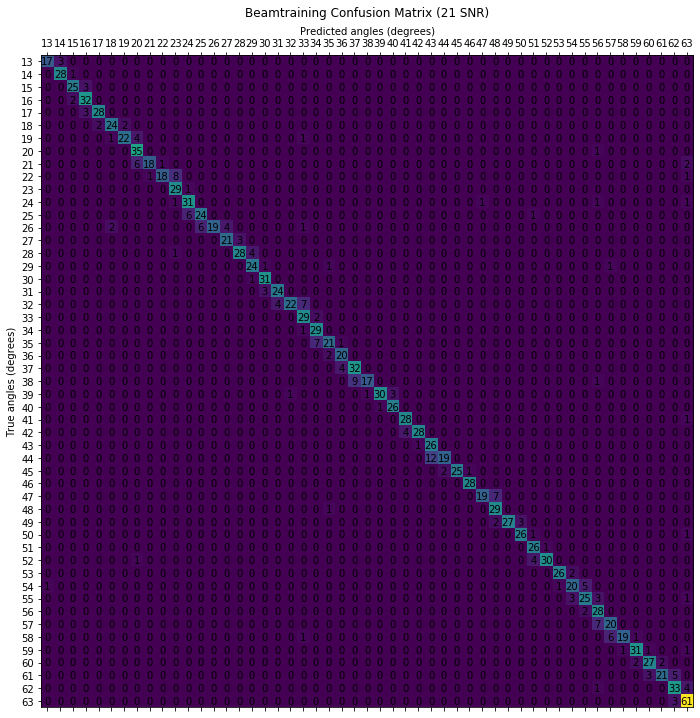

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7424 - sparse_categorical_accuracy: 0.8452
	Test accuracy: 0.8451613


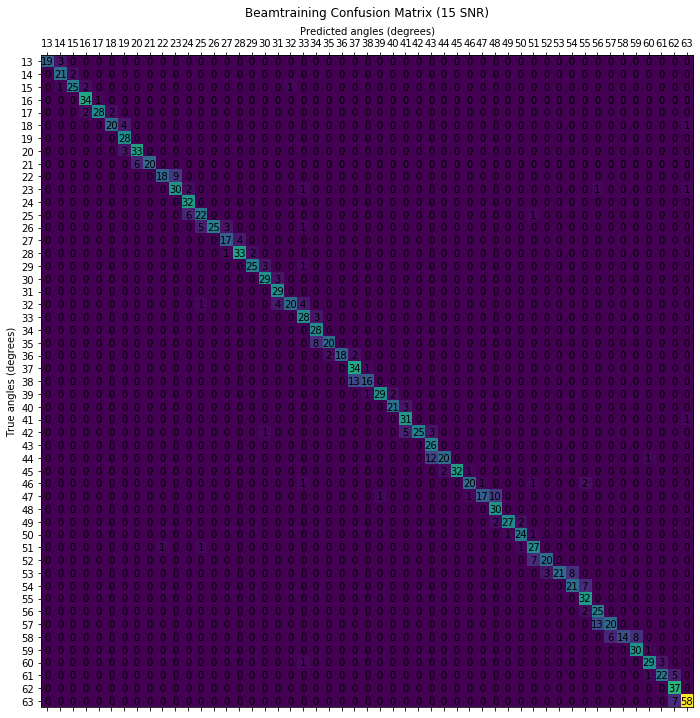

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.7165 - sparse_categorical_accuracy: 0.8582
	Test accuracy: 0.8582474


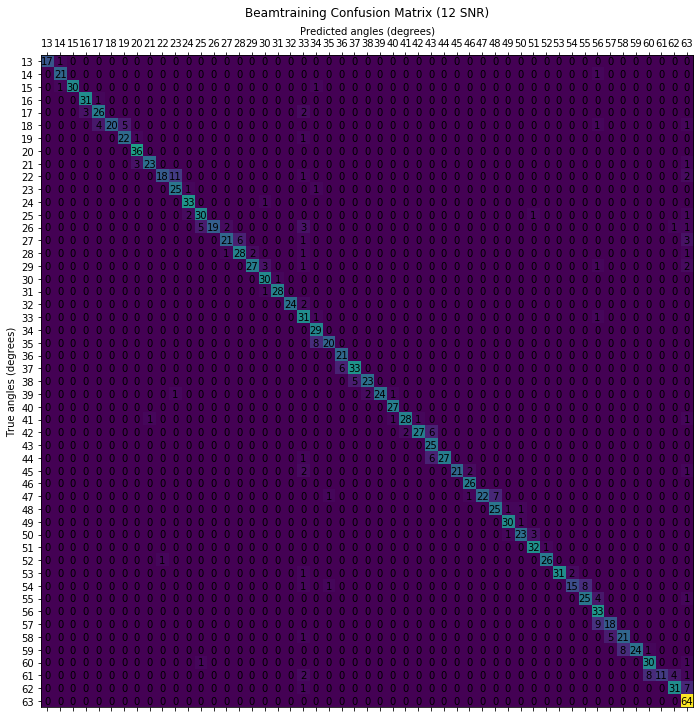

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7130 - sparse_categorical_accuracy: 0.8530
	Test accuracy: 0.8529665


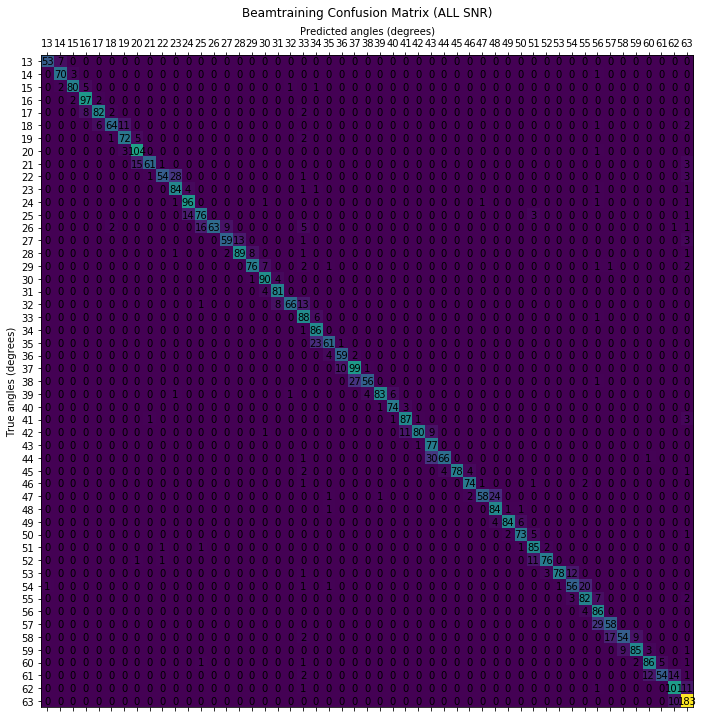


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.266432]
 [100.        36.759921]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.47495 ]
 [100.        38.410763]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

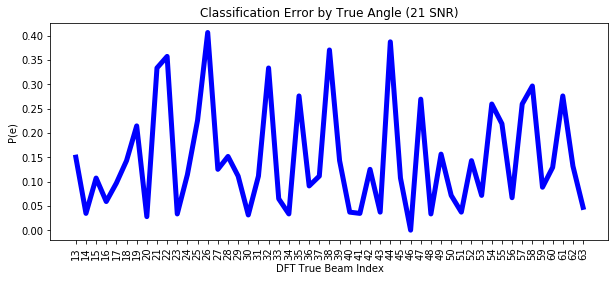

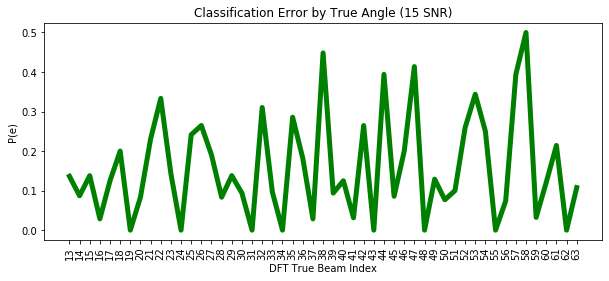

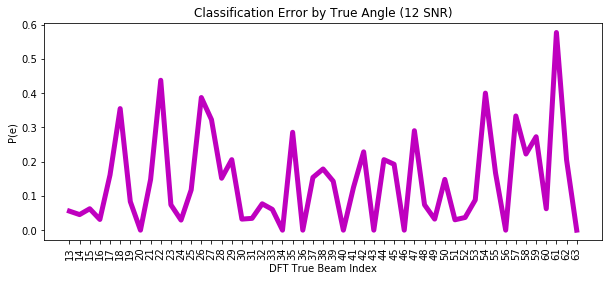

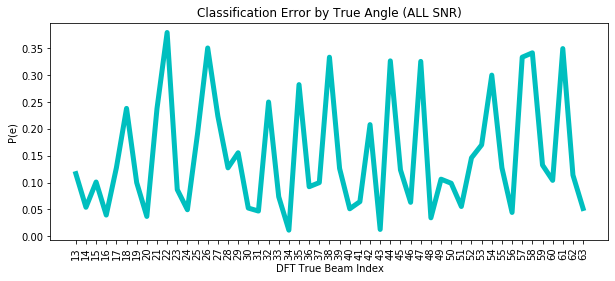

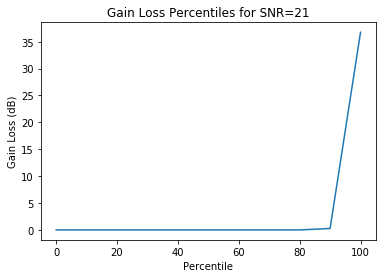

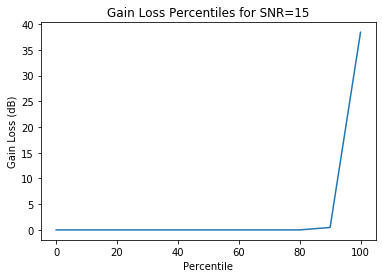

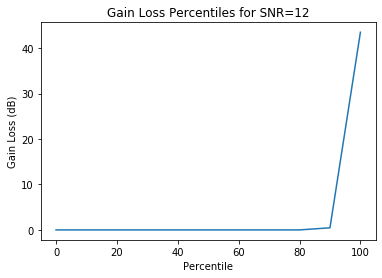

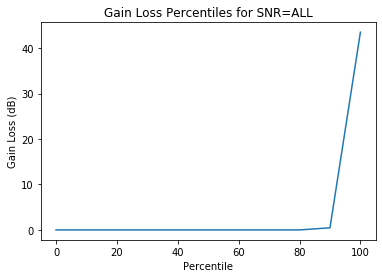

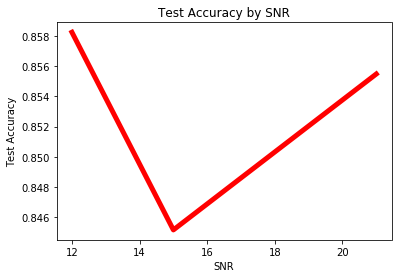

In [112]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 16 Measurements


Training model for PN combo 0...
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_44 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,755
Trainable params: 16,371
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

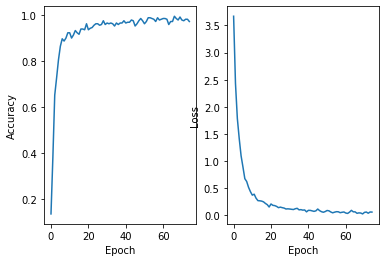

In [115]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6550 - sparse_categorical_accuracy: 0.8677
	Test accuracy: 0.86774194


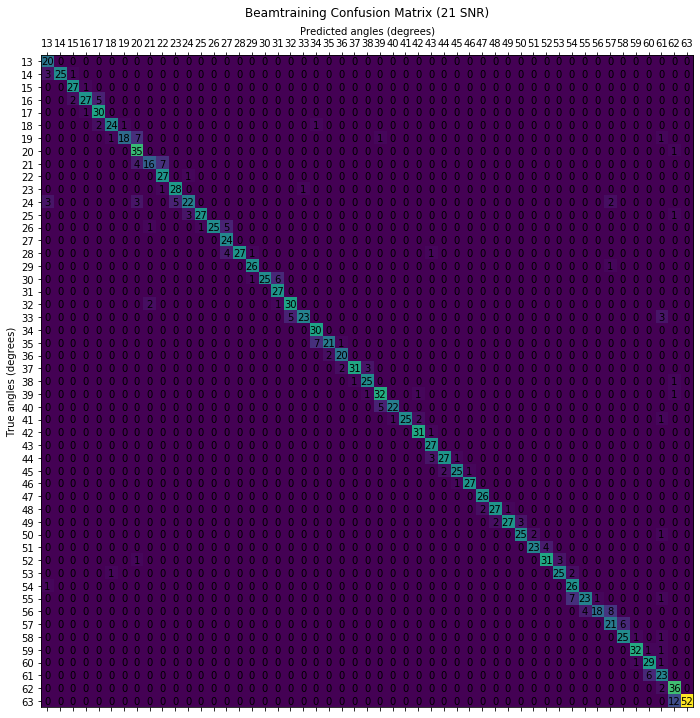

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7380 - sparse_categorical_accuracy: 0.8645
	Test accuracy: 0.86451614


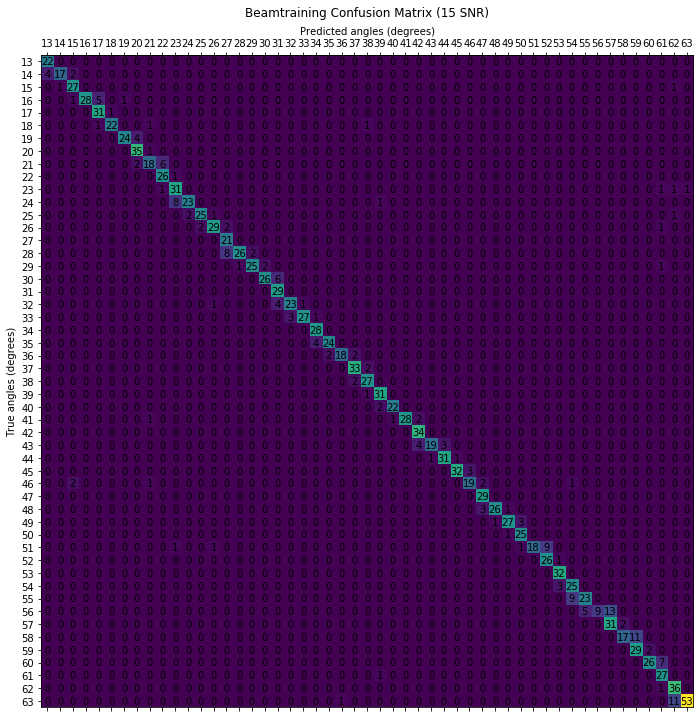

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.8390 - sparse_categorical_accuracy: 0.8434
	Test accuracy: 0.84342784


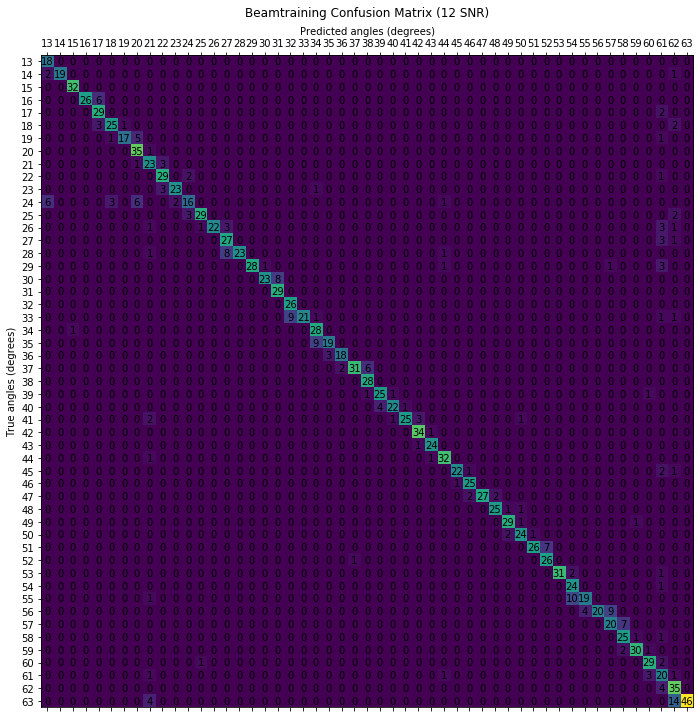

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7440 - sparse_categorical_accuracy: 0.8586
	Test accuracy: 0.85855544


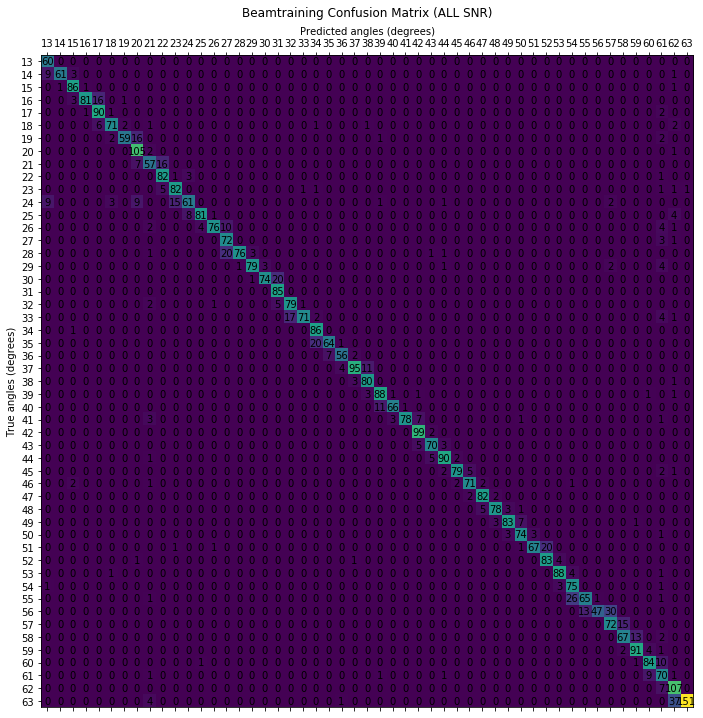


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.252175]
 [100.        36.059384]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.375568]
 [100.        37.979994]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

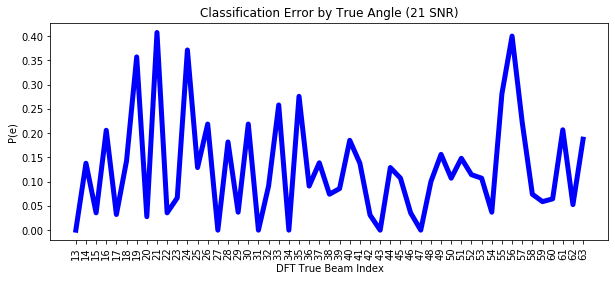

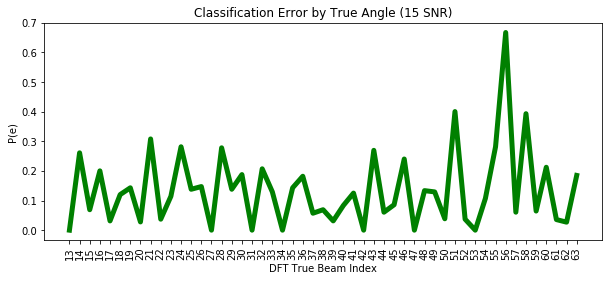

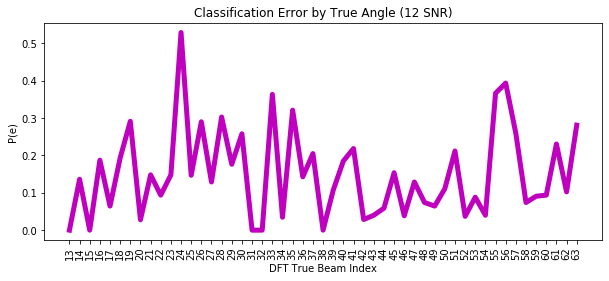

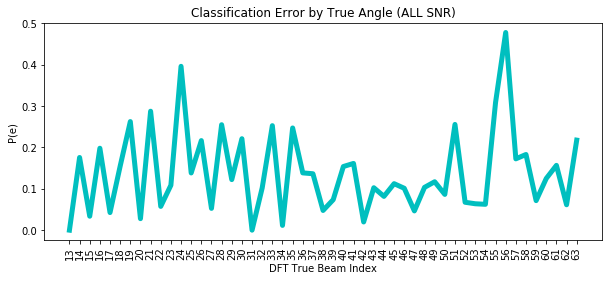

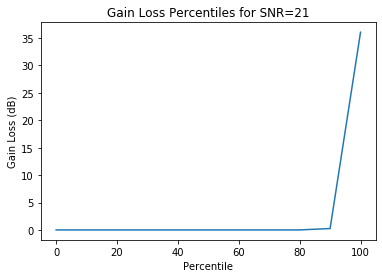

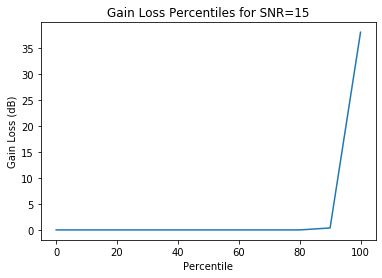

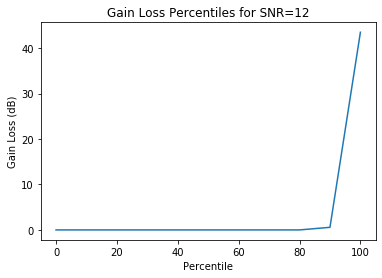

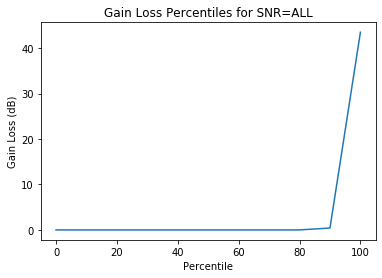

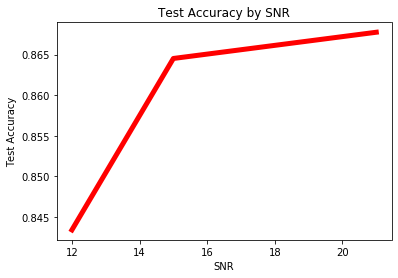

In [116]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 15 Measurements


Training model for PN combo 0...
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
batch_normalization_46 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,691
Trainable params: 16,307
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

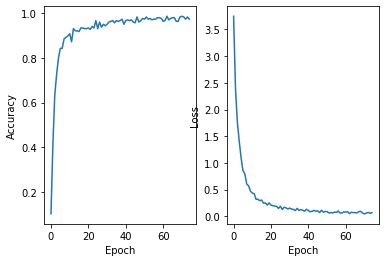

In [119]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6354 - sparse_categorical_accuracy: 0.8697
	Test accuracy: 0.8696774


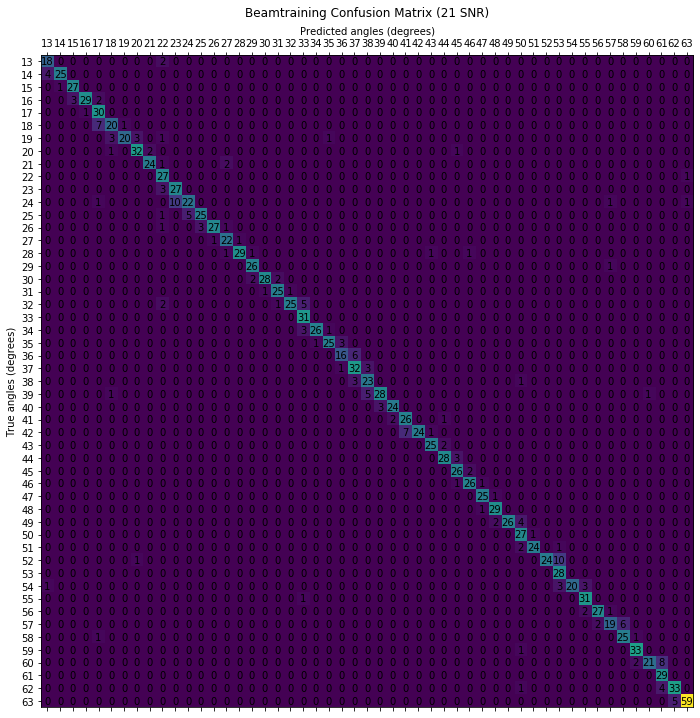

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.5769 - sparse_categorical_accuracy: 0.8729
	Test accuracy: 0.8729032


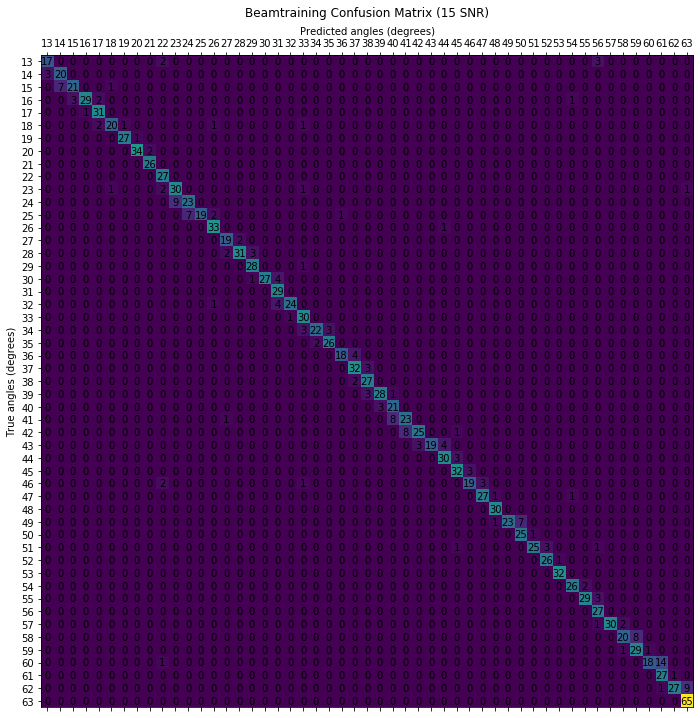

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.7102 - sparse_categorical_accuracy: 0.8454
	Test accuracy: 0.8453608


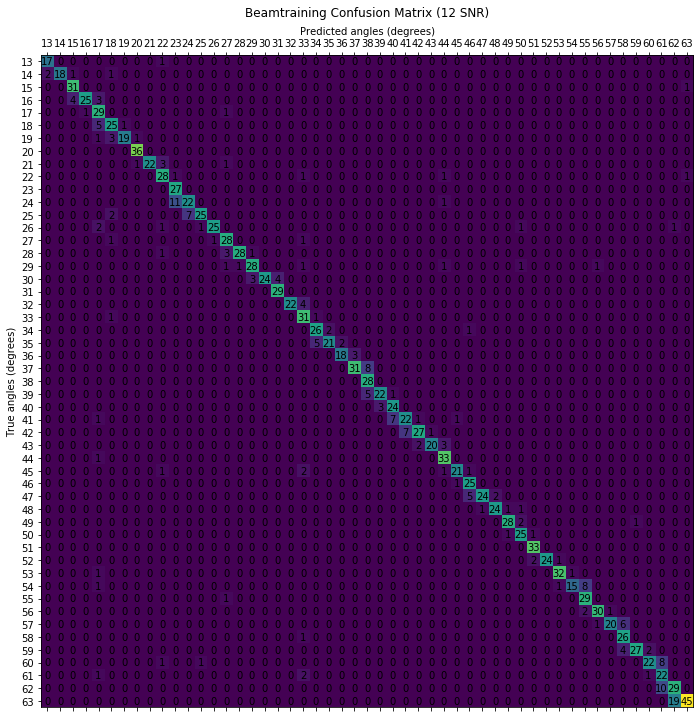

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.6408 - sparse_categorical_accuracy: 0.8626
	Test accuracy: 0.8626397


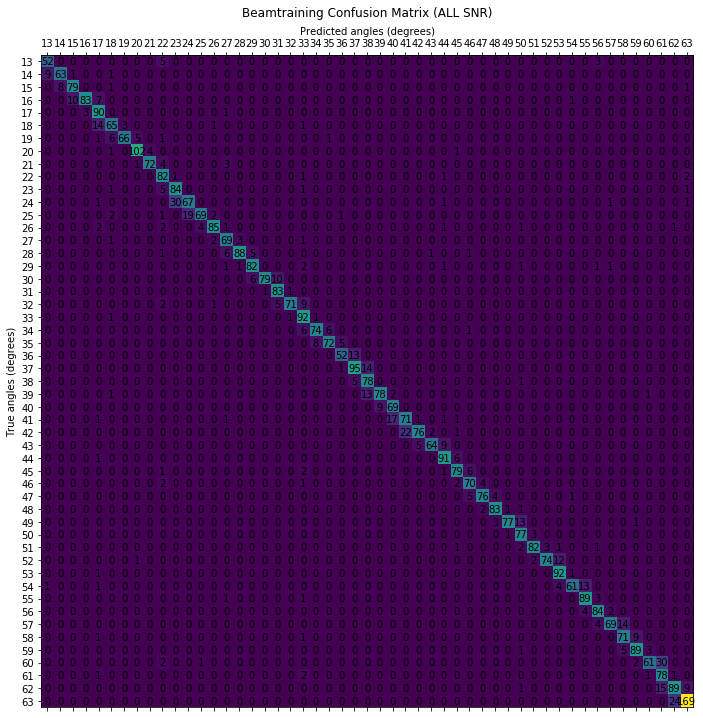


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.238525]
 [100.        36.759921]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.121011]
 [100.        37.303317]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

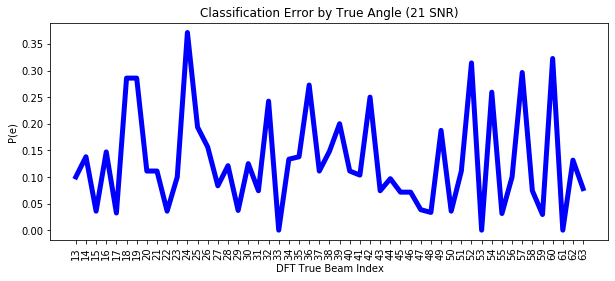

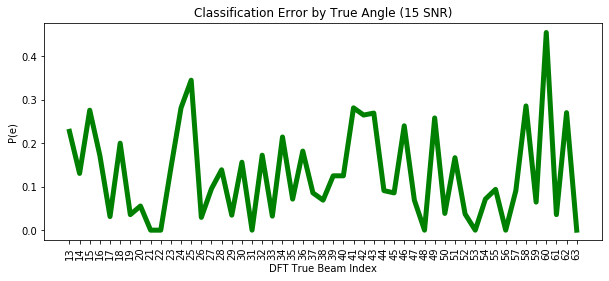

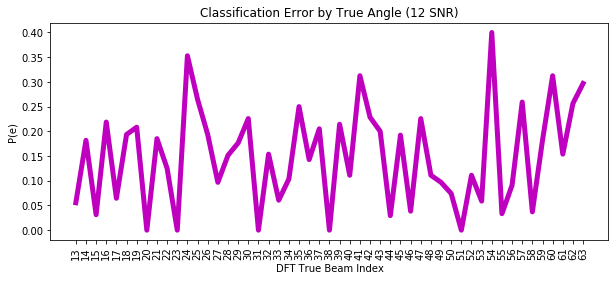

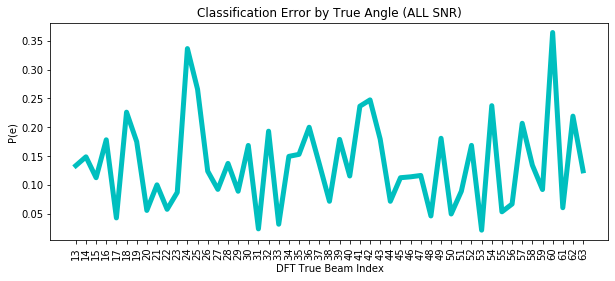

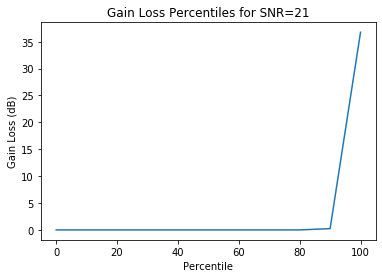

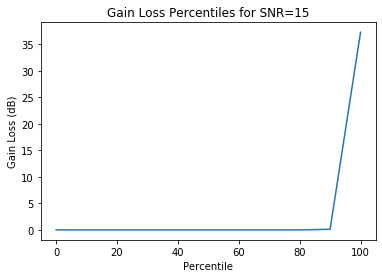

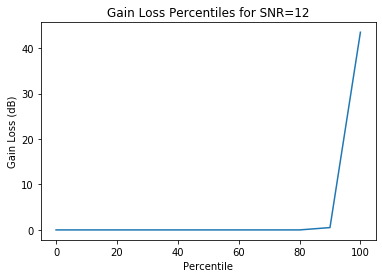

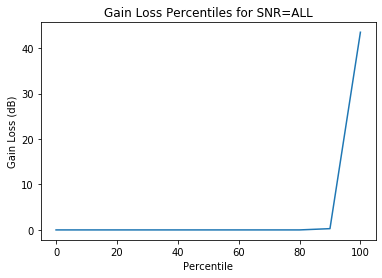

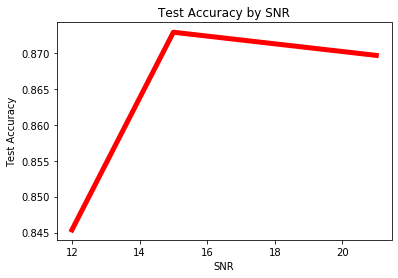

In [120]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 12 Measurements


Training model for PN combo 0...
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                832       
_________________________________________________________________
batch_normalization_48 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_49 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,499
Trainable params: 16,115
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

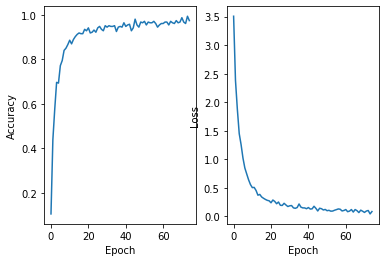

In [123]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6843 - sparse_categorical_accuracy: 0.8606
	Test accuracy: 0.8606452


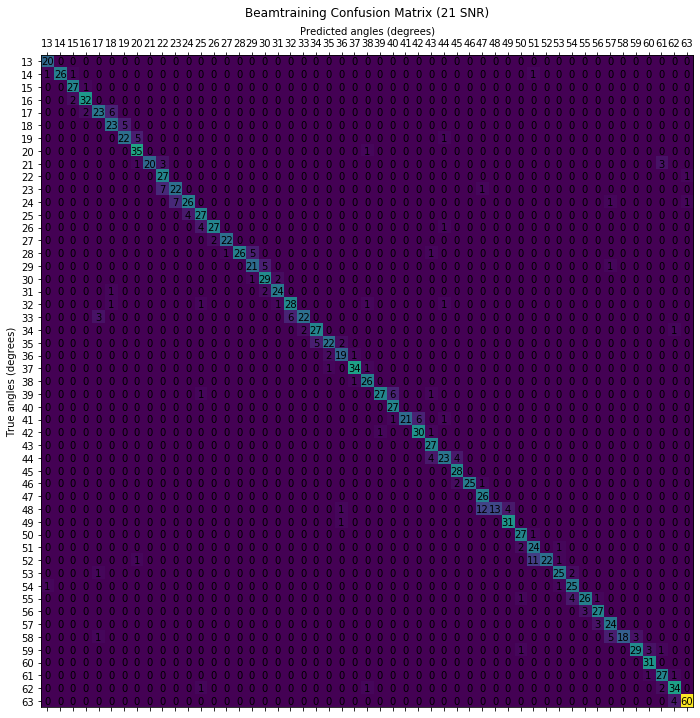

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6666 - sparse_categorical_accuracy: 0.8787
	Test accuracy: 0.8787097


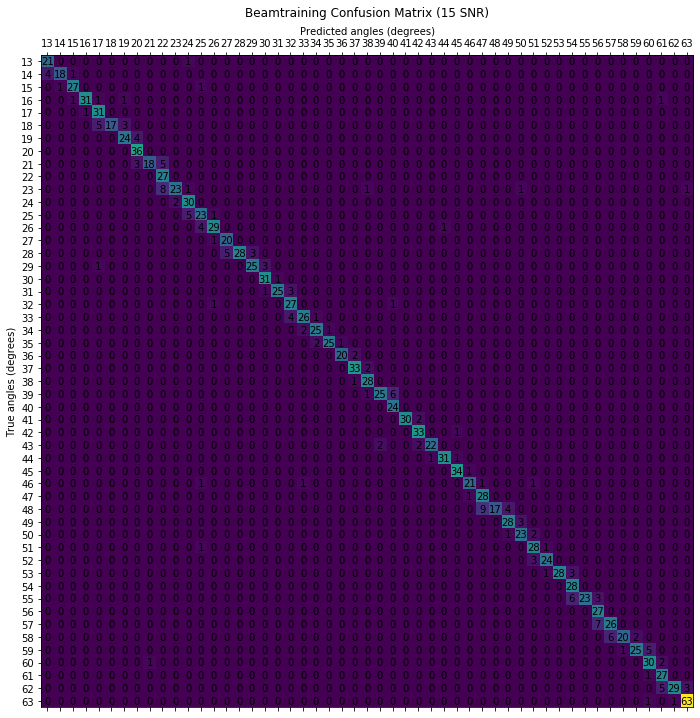

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.7606 - sparse_categorical_accuracy: 0.8428
	Test accuracy: 0.8427835


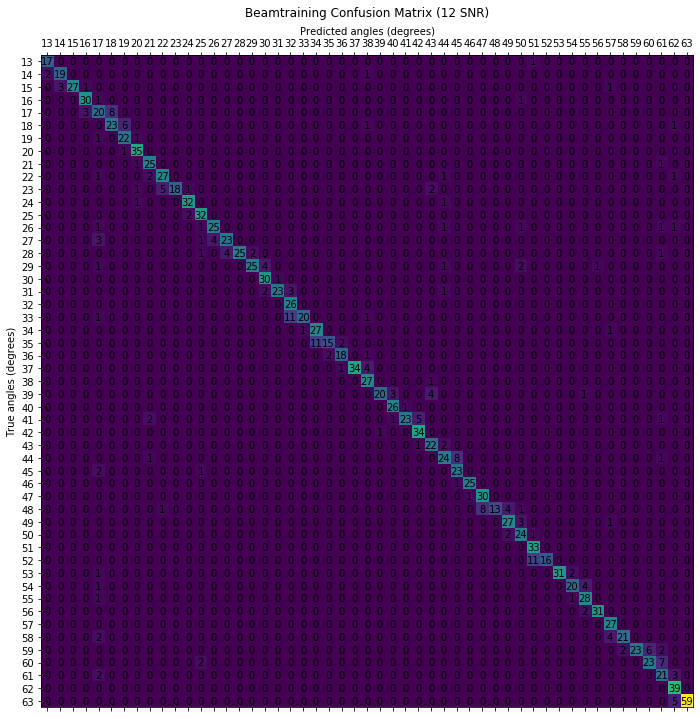

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7039 - sparse_categorical_accuracy: 0.8607
	Test accuracy: 0.8607051


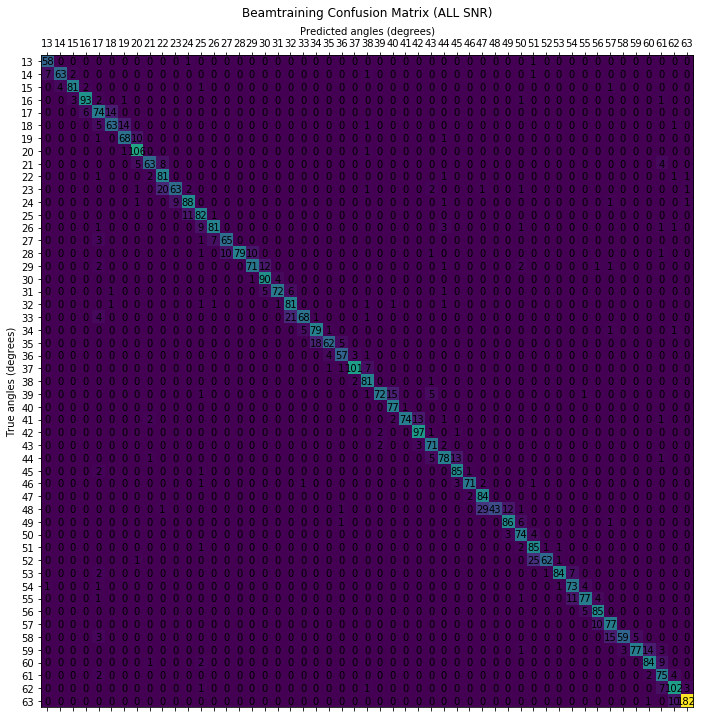


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.332951]
 [100.        36.946165]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.103473]
 [100.        37.303317]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

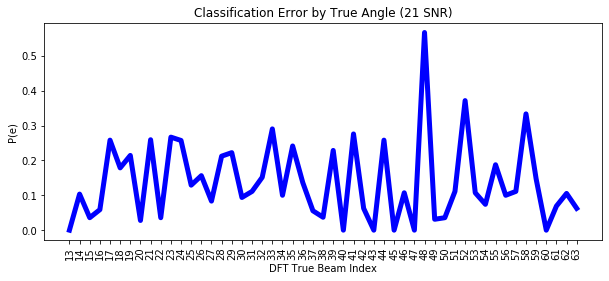

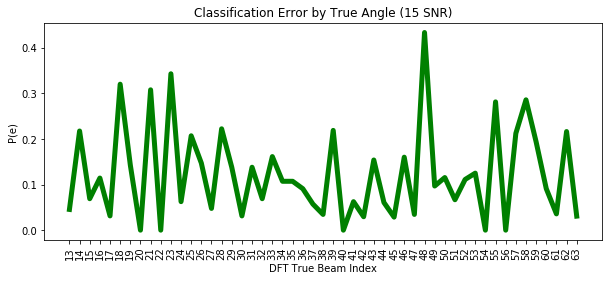

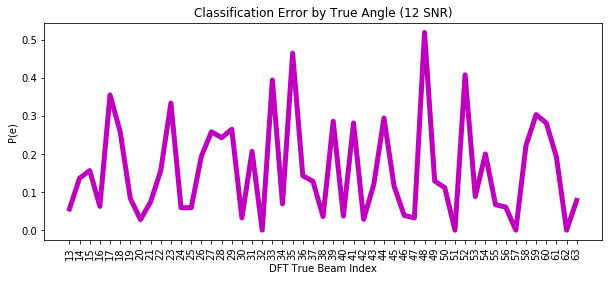

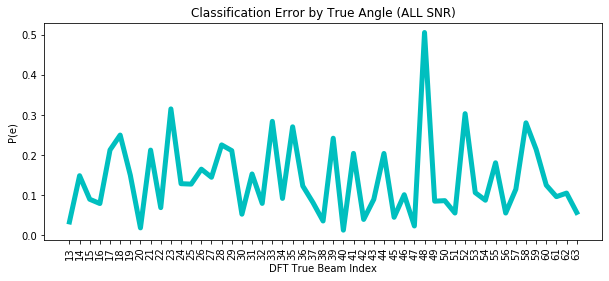

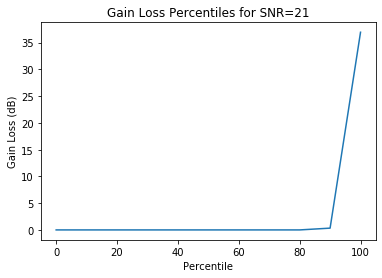

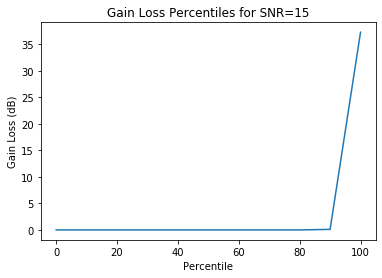

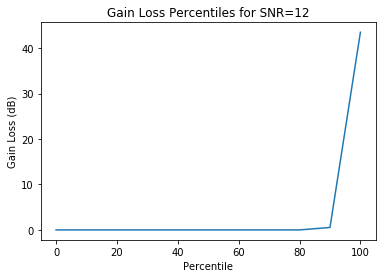

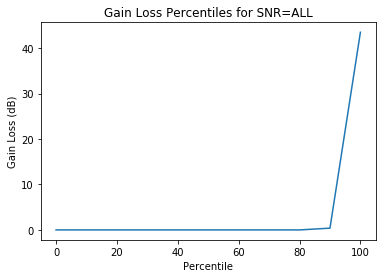

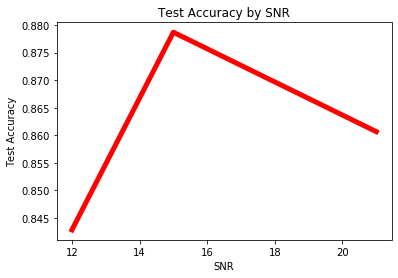

In [124]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 10 Measurements


Training model for PN combo 0...
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
batch_normalization_50 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,371
Trainable params: 15,987
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

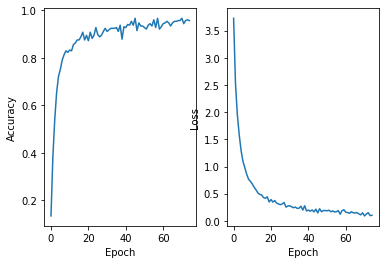

In [127]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6855 - sparse_categorical_accuracy: 0.8665
	Test accuracy: 0.8664516


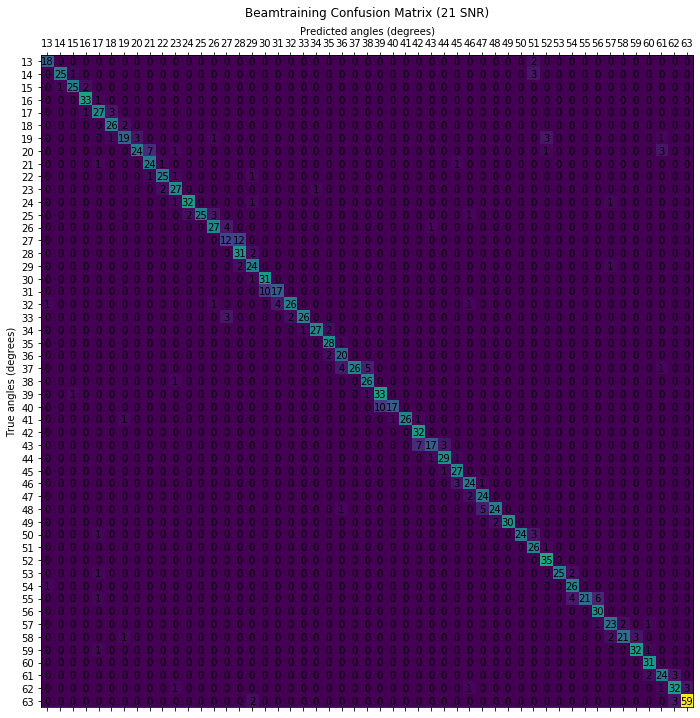

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6320 - sparse_categorical_accuracy: 0.8729
	Test accuracy: 0.8729032


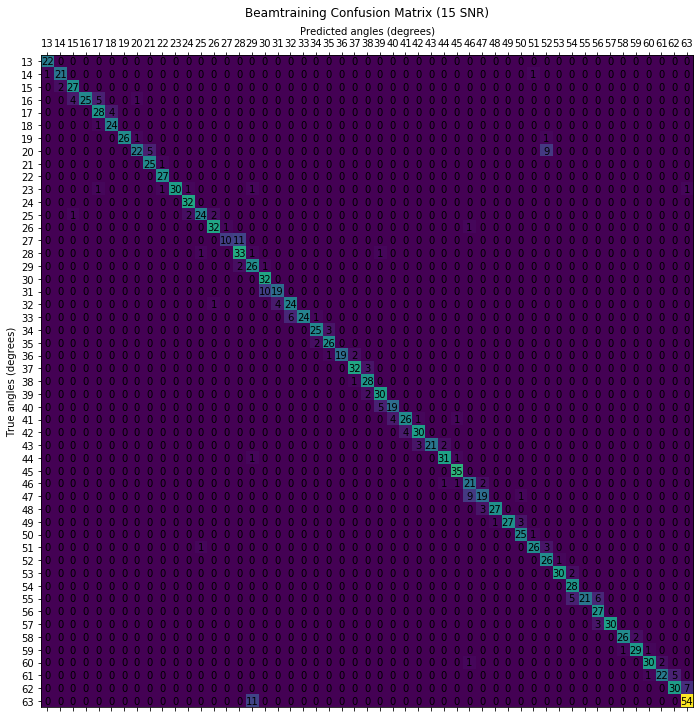

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.8209 - sparse_categorical_accuracy: 0.8305
	Test accuracy: 0.83054125


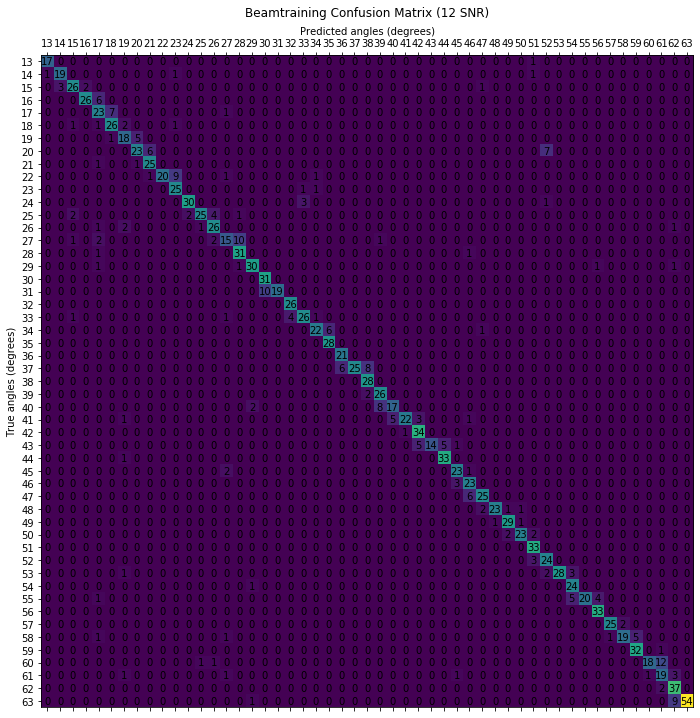

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7129 - sparse_categorical_accuracy: 0.8566
	Test accuracy: 0.8566208


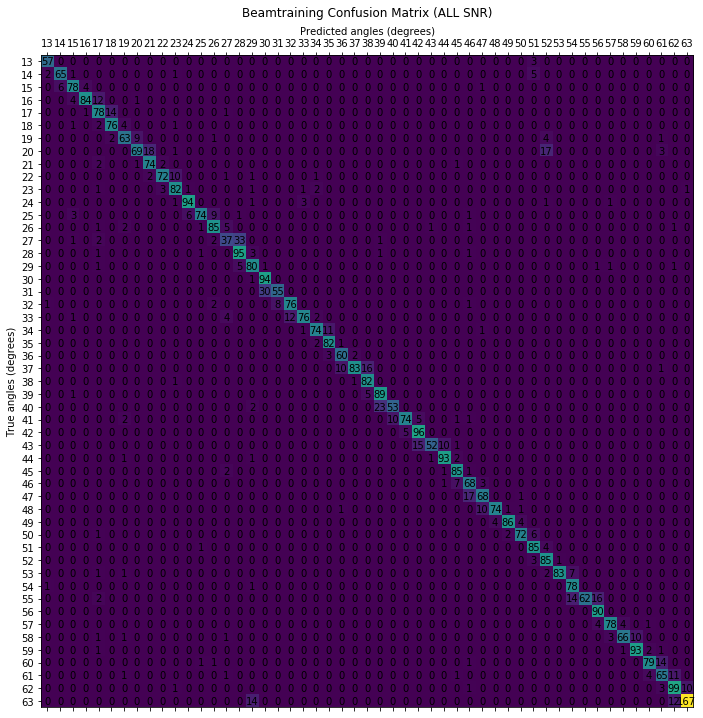


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.25886 ]
 [100.        36.759921]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.251025]
 [100.        39.086684]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

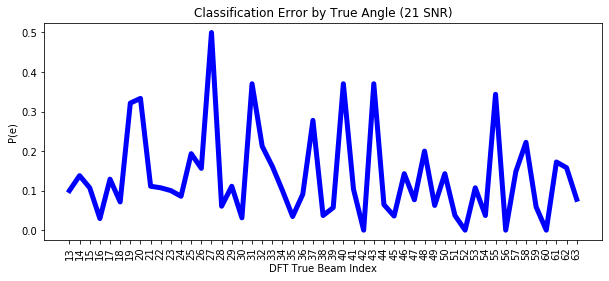

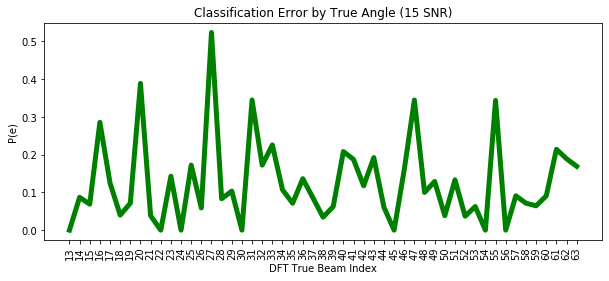

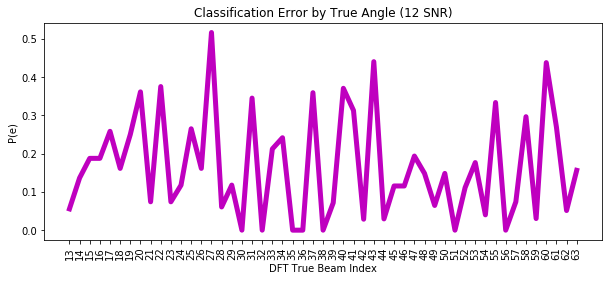

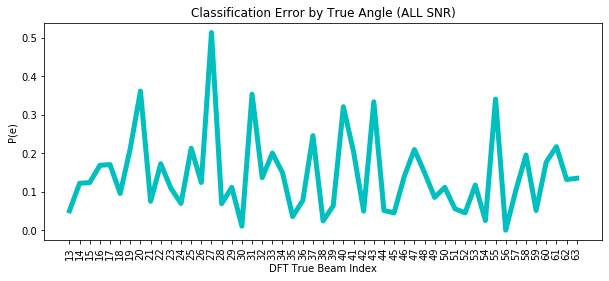

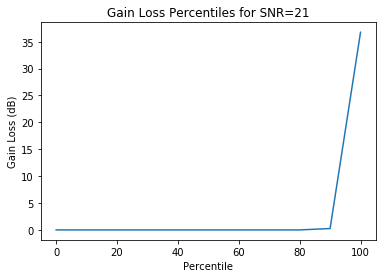

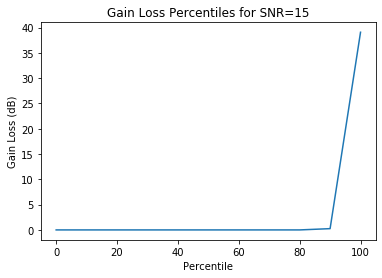

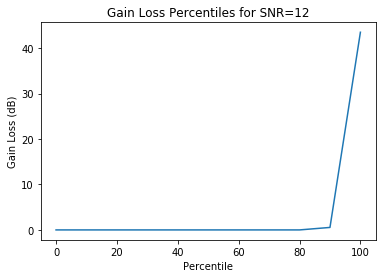

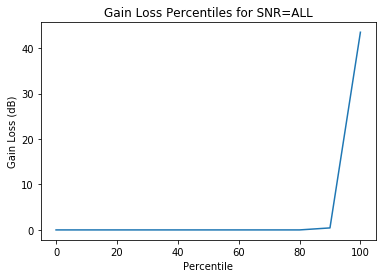

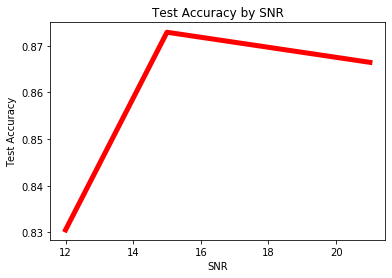

In [128]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 9 Measurements


Training model for PN combo 0...
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 9)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
batch_normalization_52 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_53 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,307
Trainable params: 15,923
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

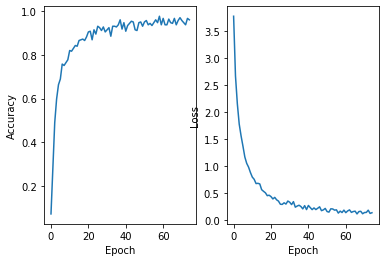

In [131]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7501 - sparse_categorical_accuracy: 0.8419
	Test accuracy: 0.84193546


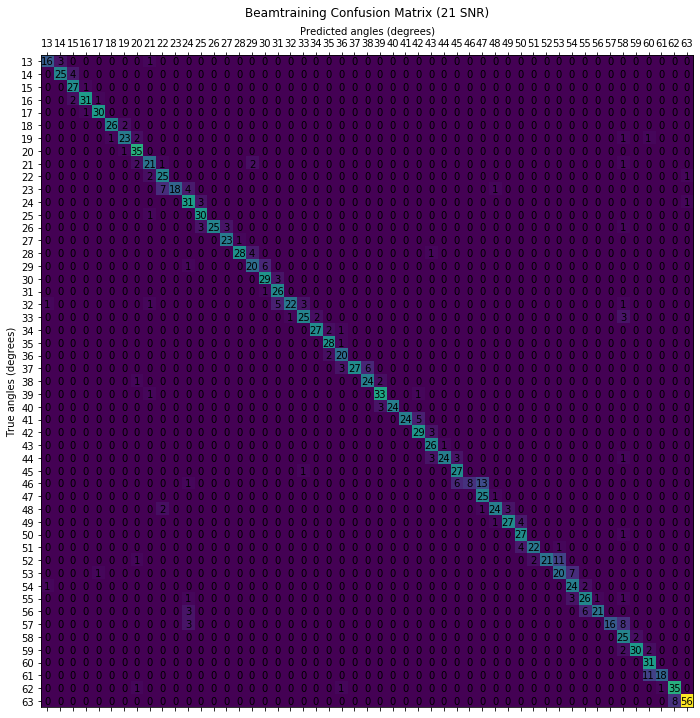

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.6850 - sparse_categorical_accuracy: 0.8671
	Test accuracy: 0.8670968


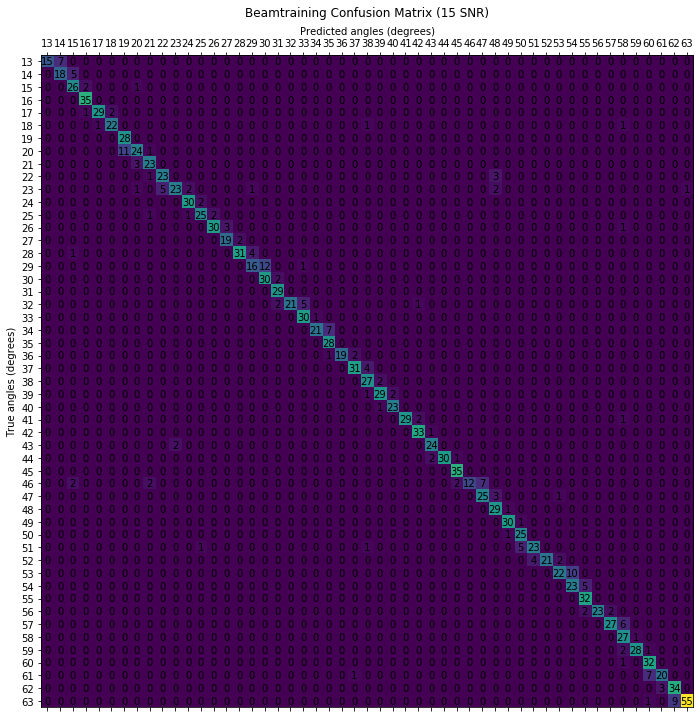

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.8717 - sparse_categorical_accuracy: 0.8370
	Test accuracy: 0.8369845


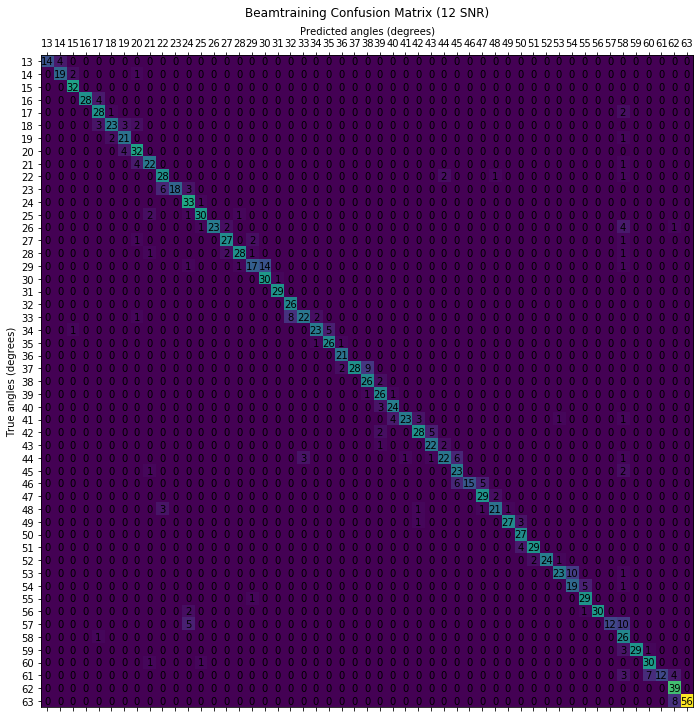

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7690 - sparse_categorical_accuracy: 0.8487
	Test accuracy: 0.84866726


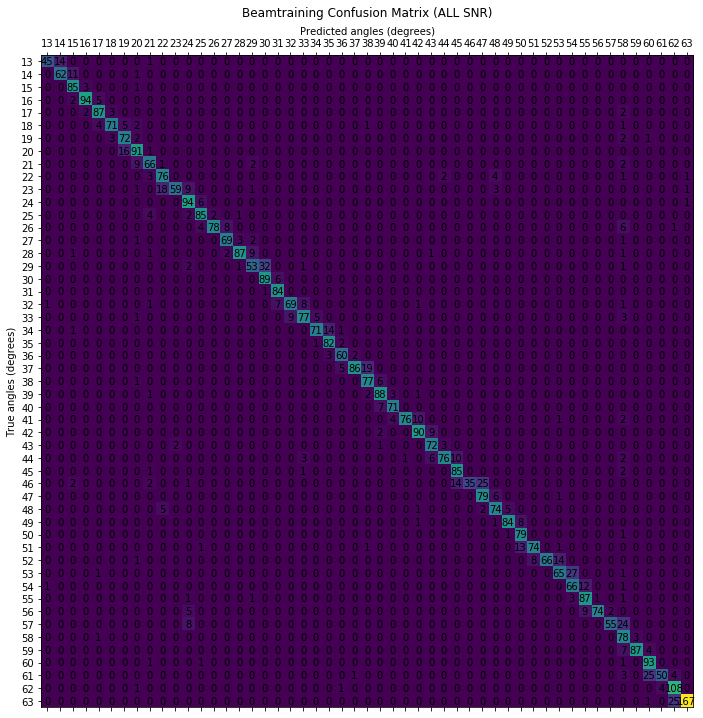


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.512767]
 [100.        48.104617]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.353939]
 [100.        39.438709]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

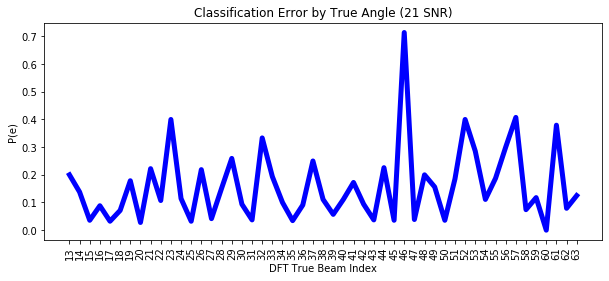

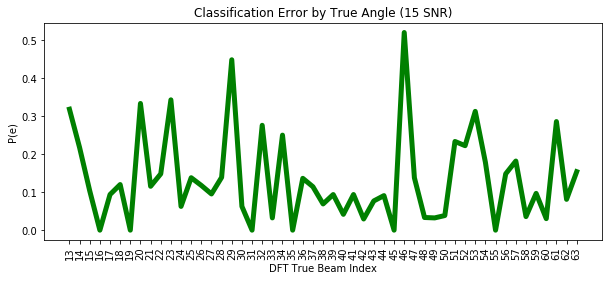

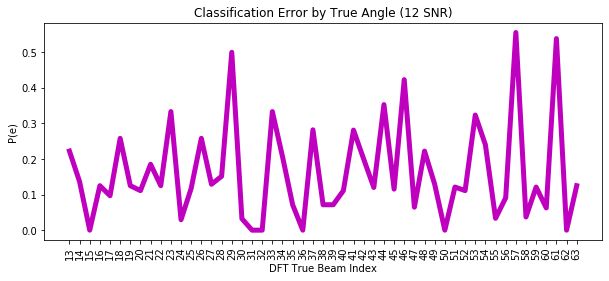

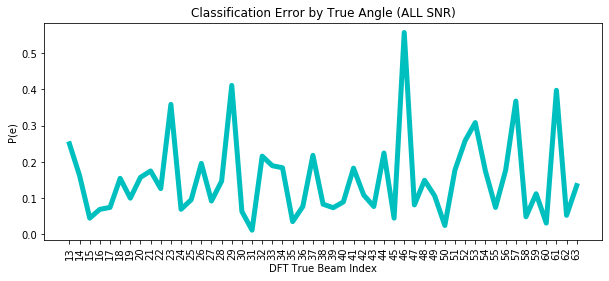

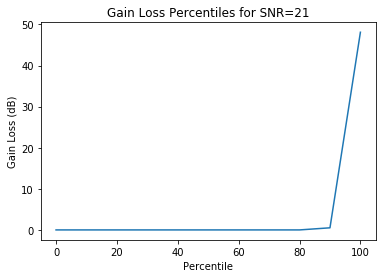

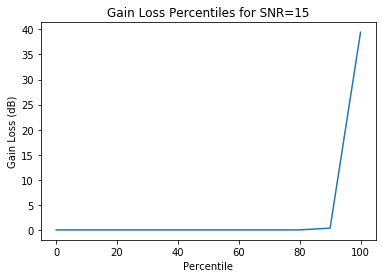

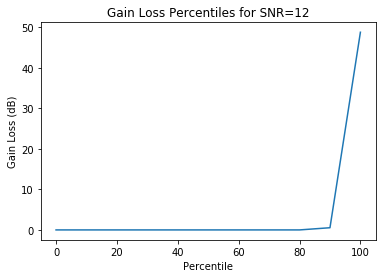

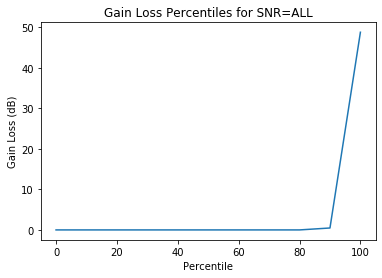

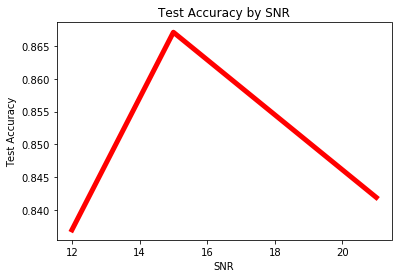

In [132]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
batch_normalization_54 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,243
Trainable params: 15,859
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

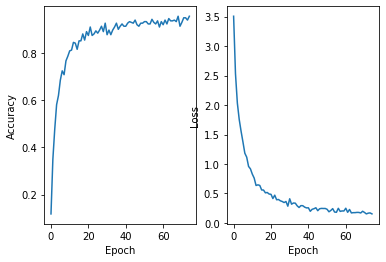

In [135]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7611 - sparse_categorical_accuracy: 0.8323
	Test accuracy: 0.83225805


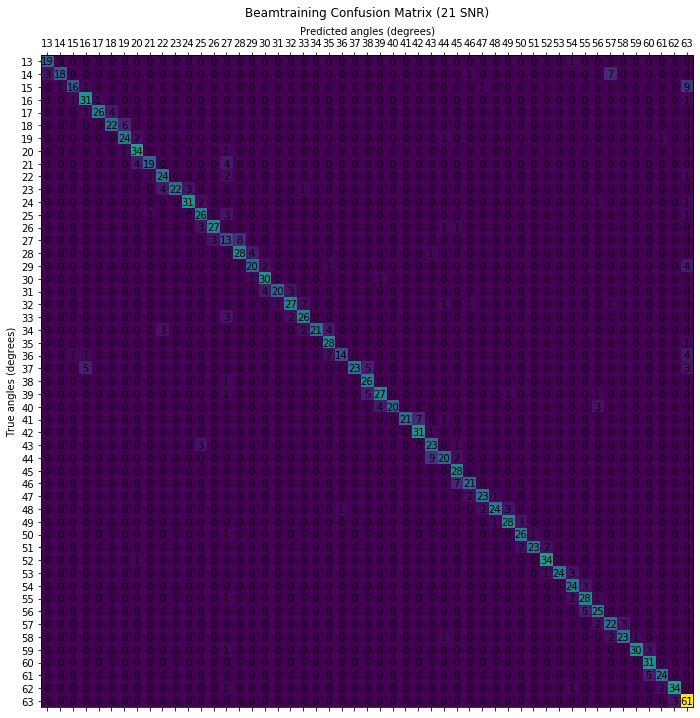

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7412 - sparse_categorical_accuracy: 0.8735
	Test accuracy: 0.8735484


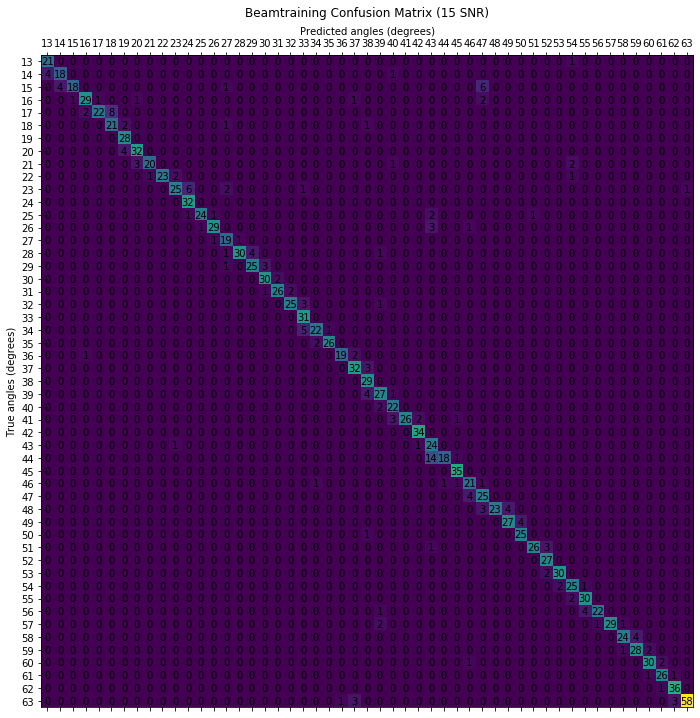

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.8200 - sparse_categorical_accuracy: 0.8241
	Test accuracy: 0.82409793


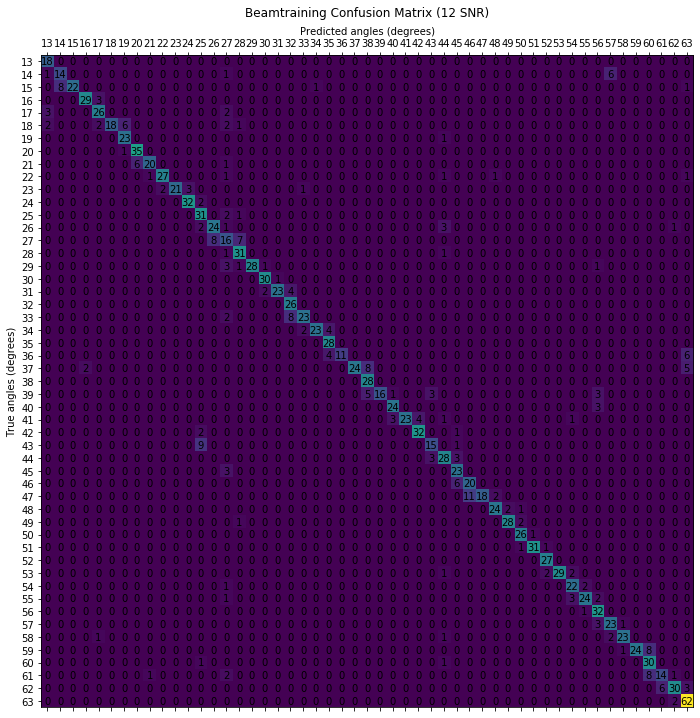

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.7741 - sparse_categorical_accuracy: 0.8433
	Test accuracy: 0.8432932


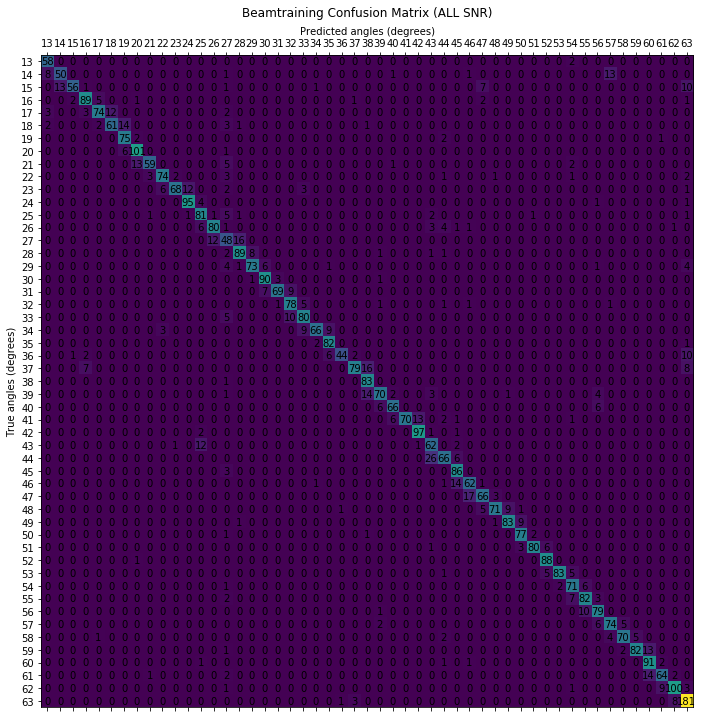


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.558041]
 [100.        37.896064]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.261712]
 [100.        39.438709]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

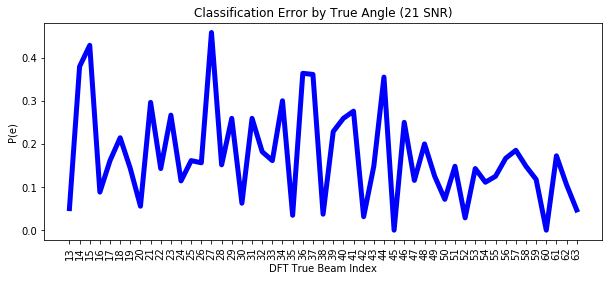

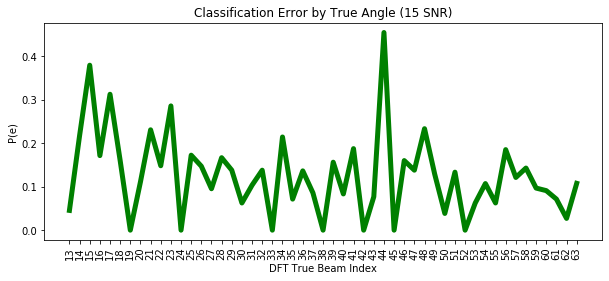

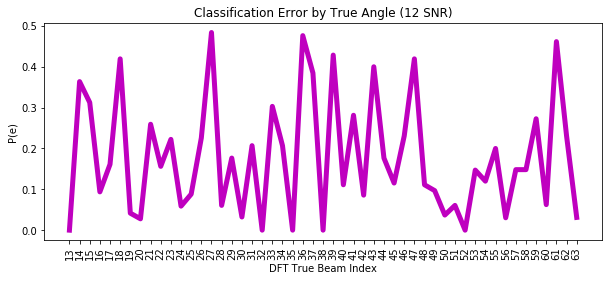

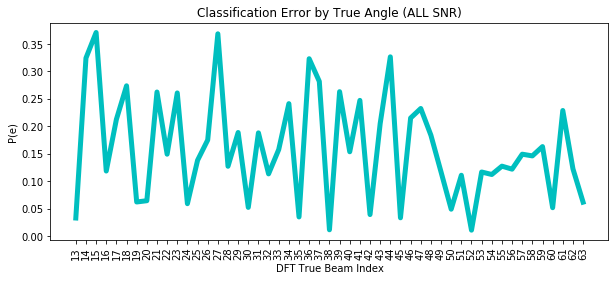

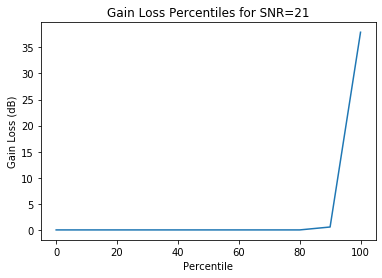

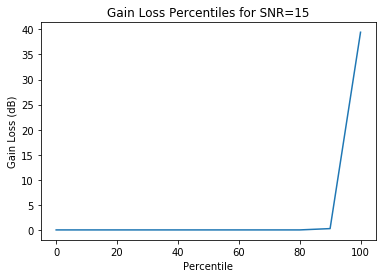

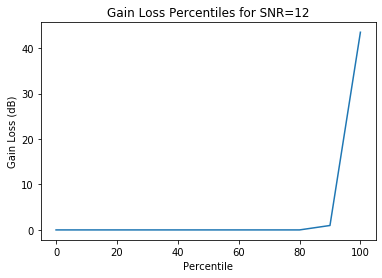

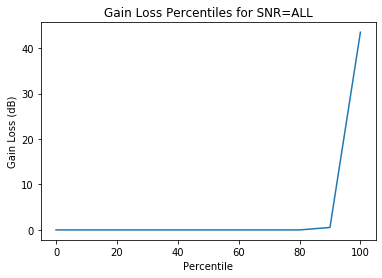

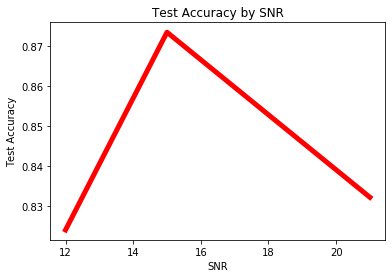

In [136]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
batch_normalization_56 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,179
Trainable params: 15,795
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

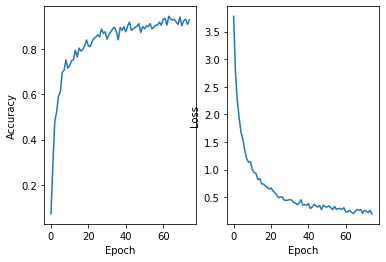

In [139]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.8450 - sparse_categorical_accuracy: 0.8174
	Test accuracy: 0.81741935


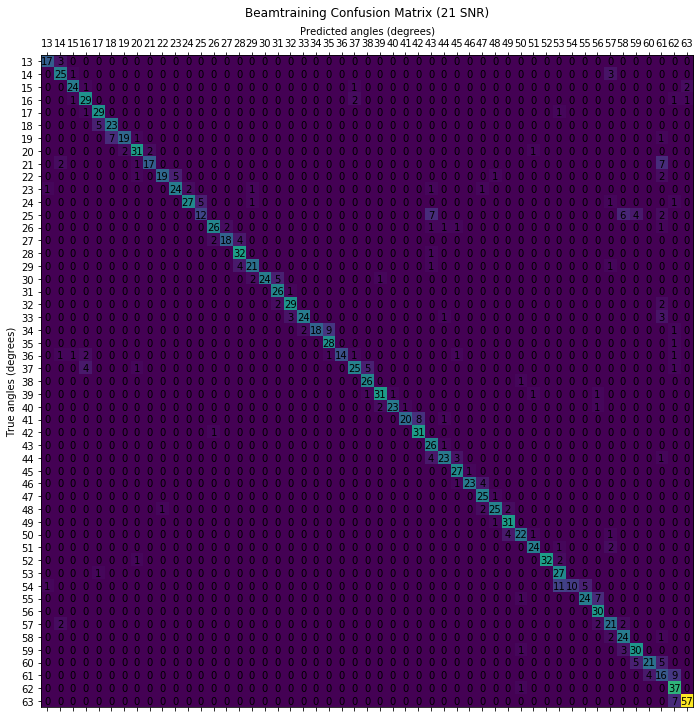

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.7955 - sparse_categorical_accuracy: 0.8323
	Test accuracy: 0.83225805


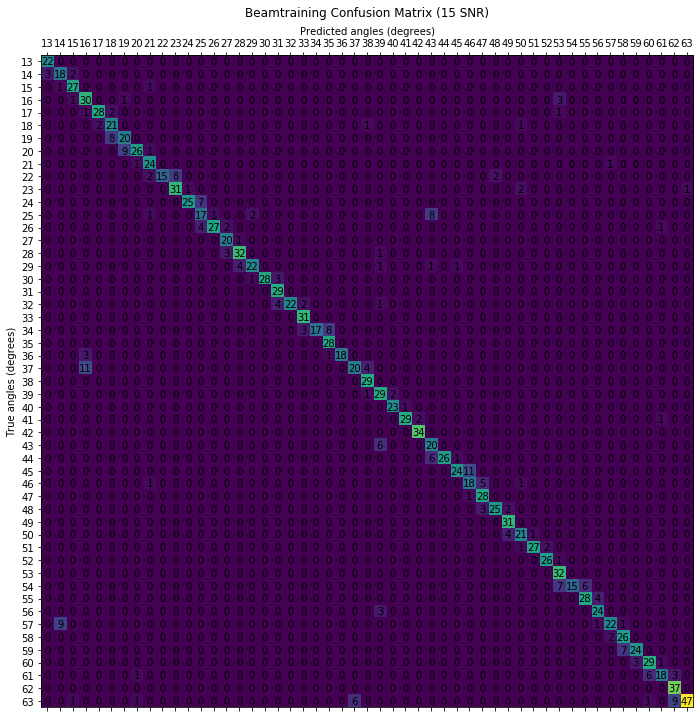

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 0.9276 - sparse_categorical_accuracy: 0.8254
	Test accuracy: 0.8253866


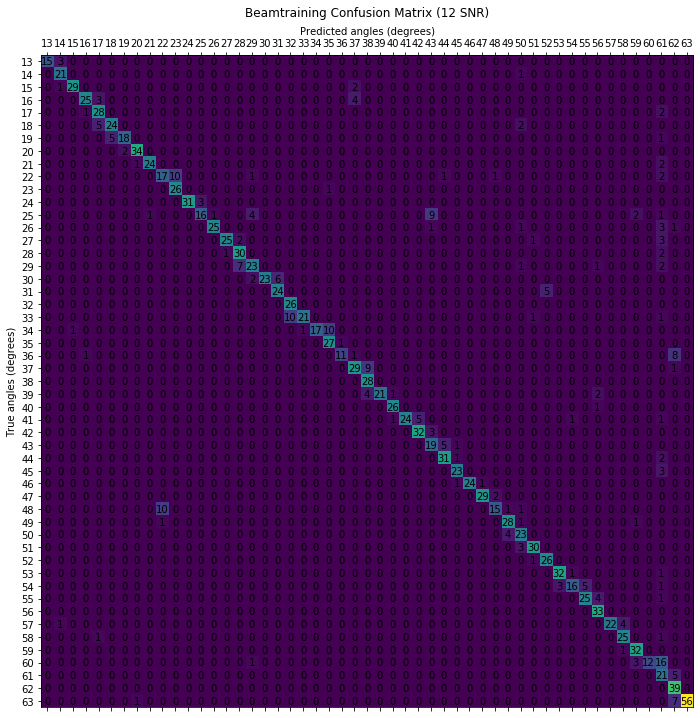

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 0.8561 - sparse_categorical_accuracy: 0.8250
	Test accuracy: 0.8250215


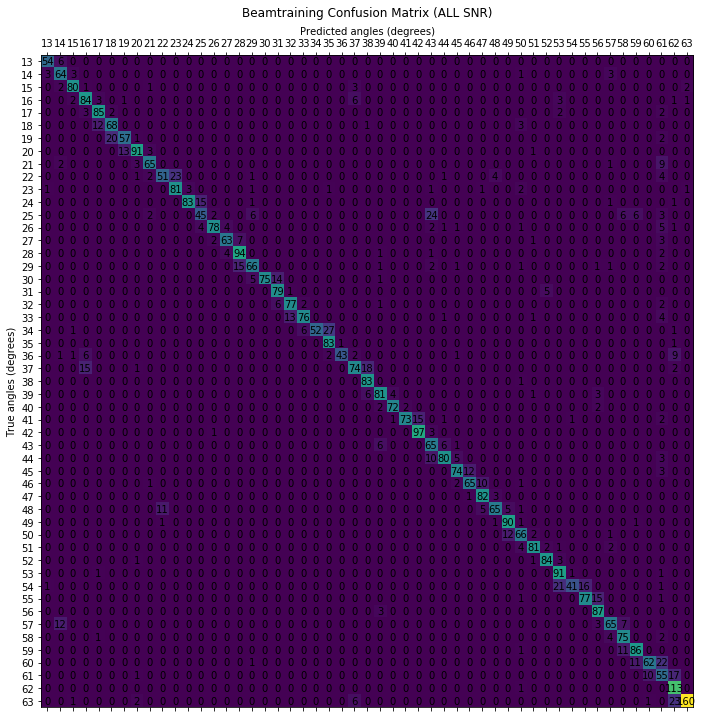


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         1.027016]
 [100.        39.343888]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.552116]
 [100.        39.942014]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

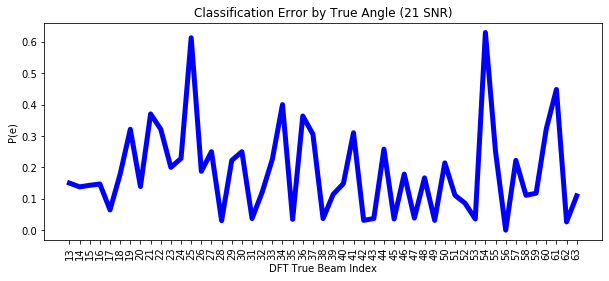

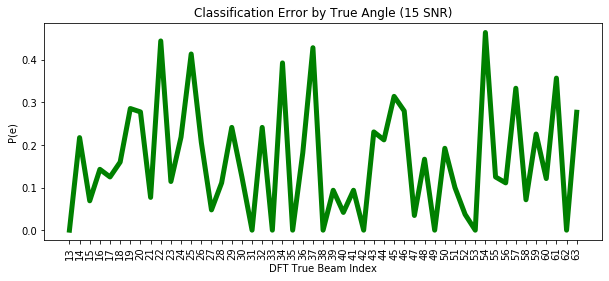

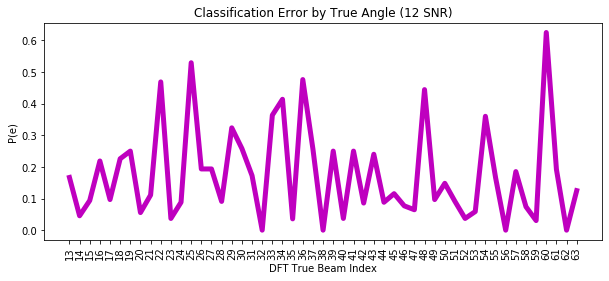

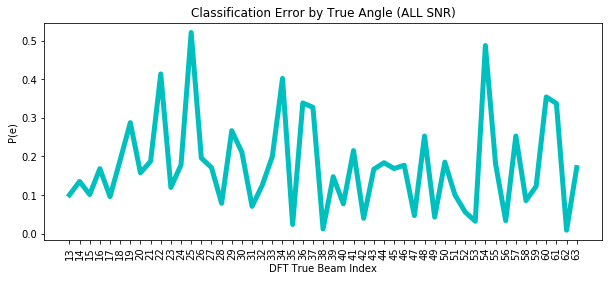

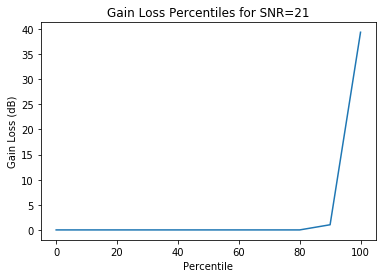

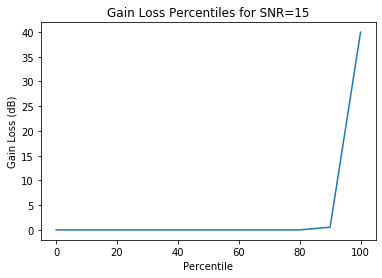

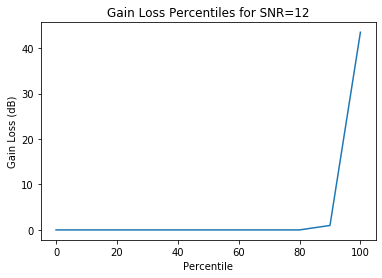

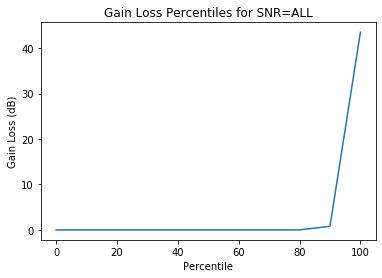

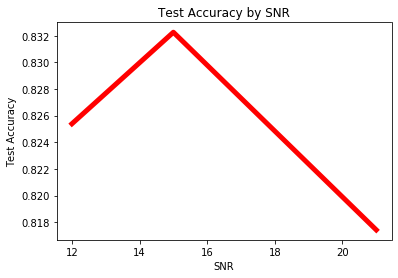

In [140]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 6)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
batch_normalization_58 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_59 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,115
Trainable params: 15,731
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

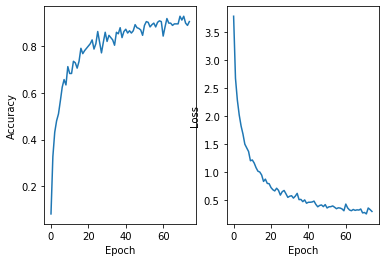

In [143]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 0.9951 - sparse_categorical_accuracy: 0.8258
	Test accuracy: 0.82580644


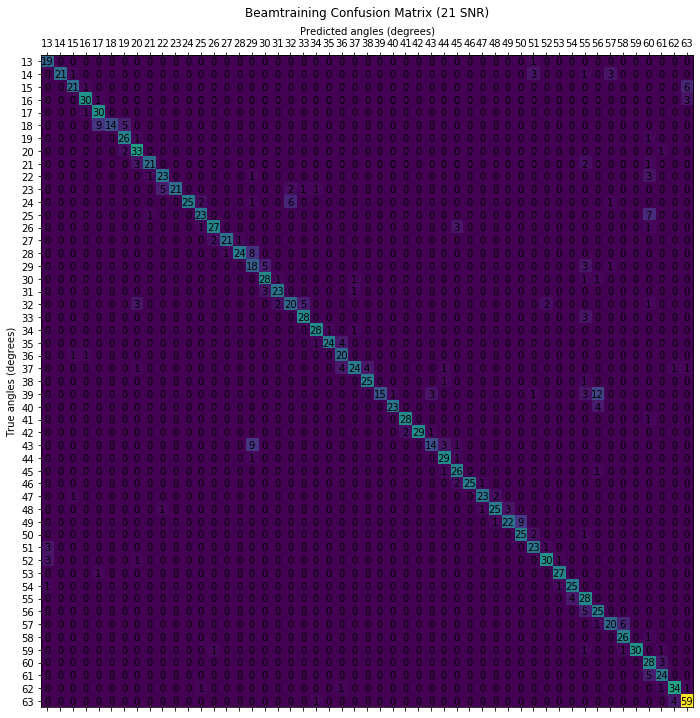

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 1.1248 - sparse_categorical_accuracy: 0.8206
	Test accuracy: 0.82064515


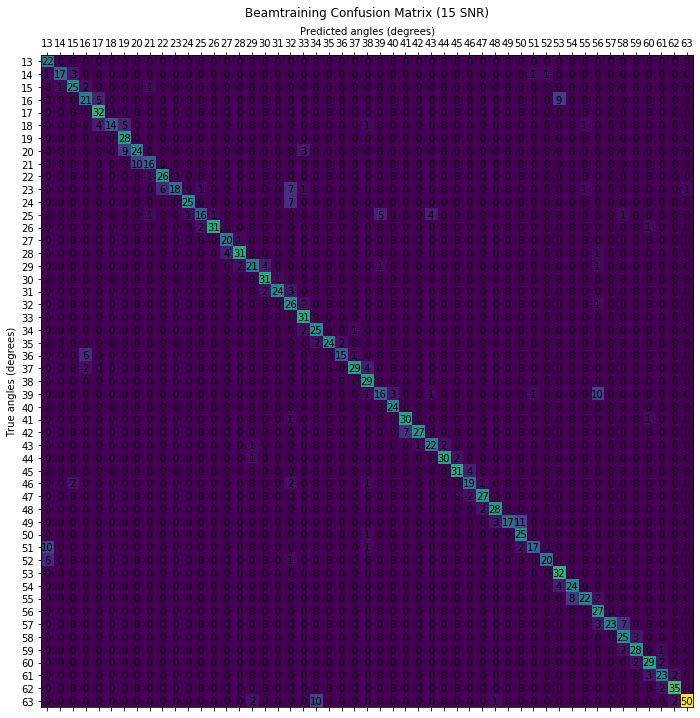

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 1.0805 - sparse_categorical_accuracy: 0.7983
	Test accuracy: 0.79832476


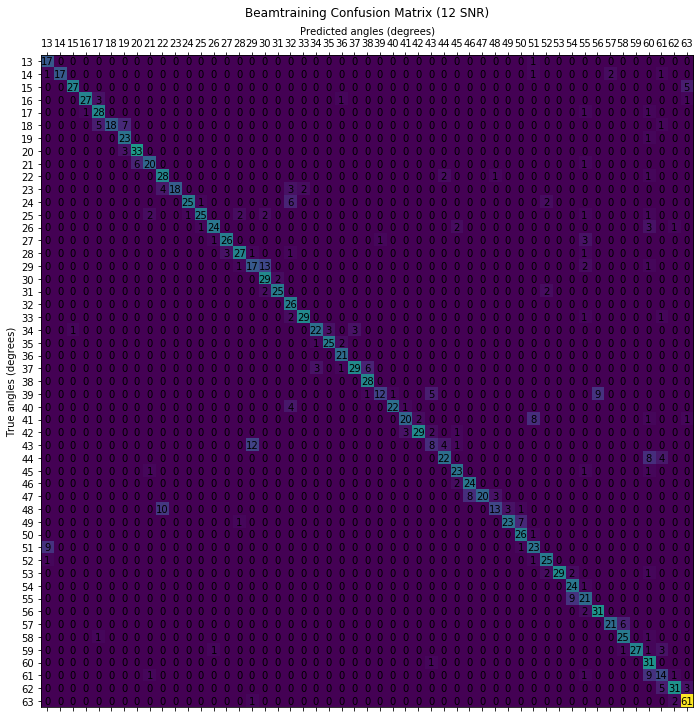

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 1.0668 - sparse_categorical_accuracy: 0.8149
	Test accuracy: 0.81491834


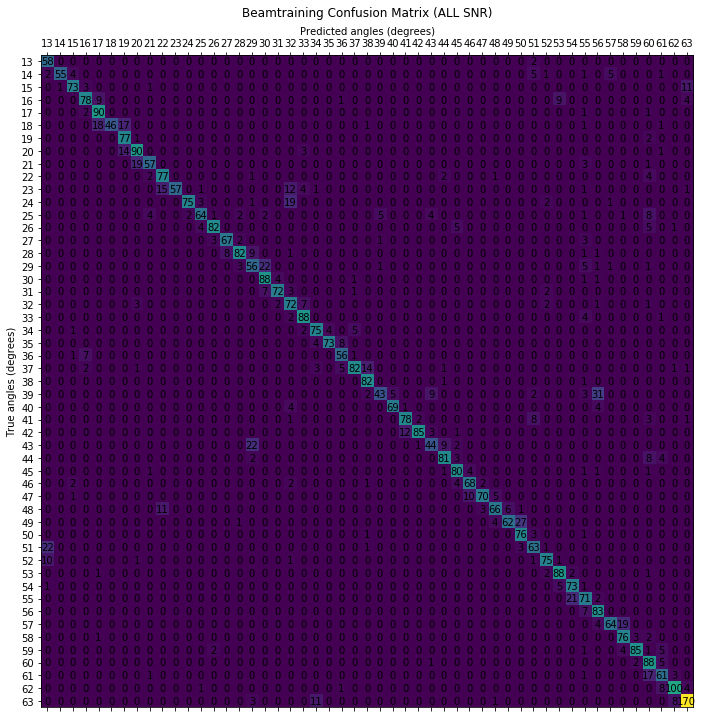


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         1.259374]
 [100.        37.896064]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         1.16352 ]
 [100.        39.942014]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

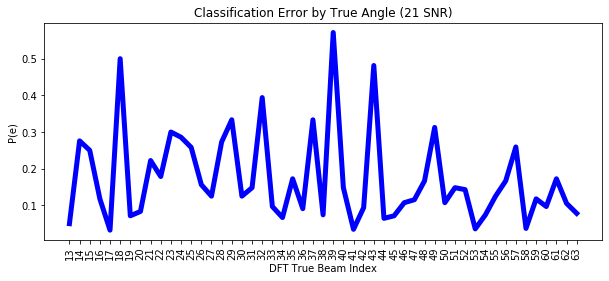

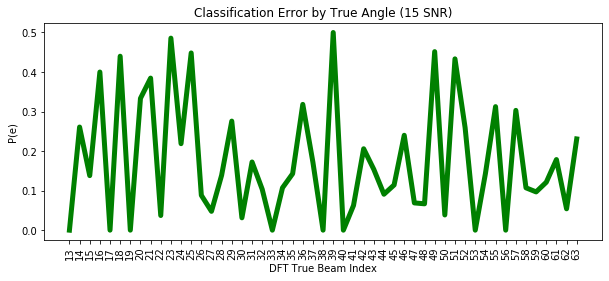

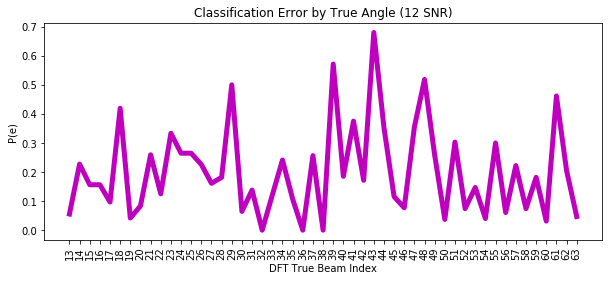

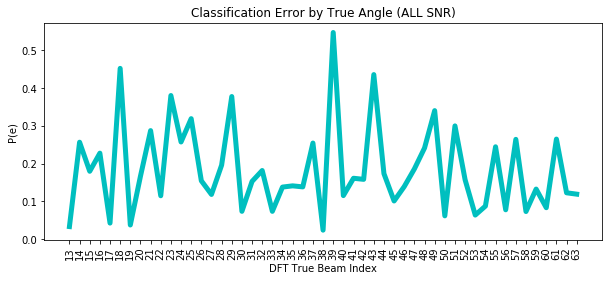

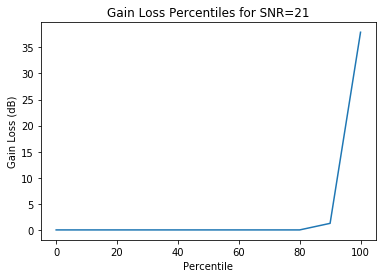

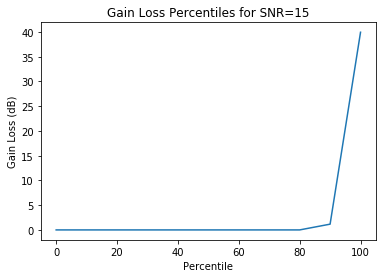

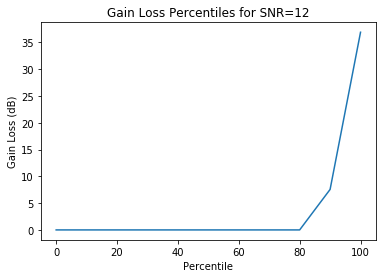

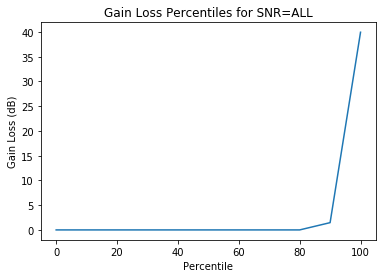

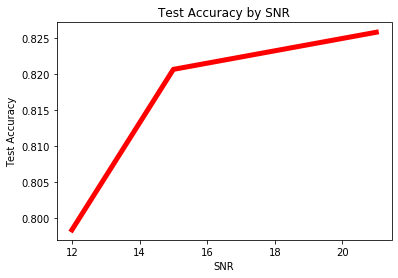

In [144]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 5 Measurements


Training model for PN combo 0...
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
batch_normalization_60 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_61 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,051
Trainable params: 15,667
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

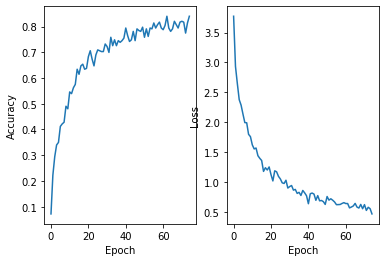

In [147]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 1.1707 - sparse_categorical_accuracy: 0.7213
	Test accuracy: 0.72129035


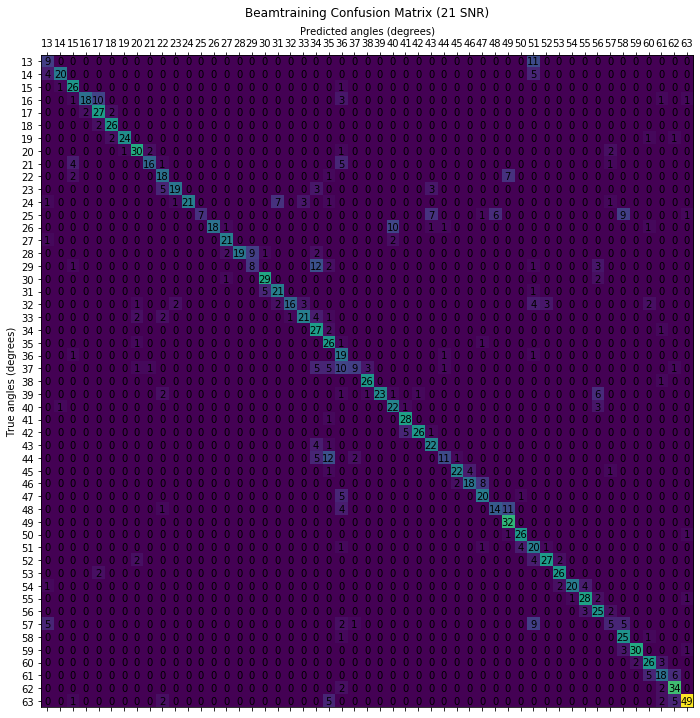

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 1.2437 - sparse_categorical_accuracy: 0.7413
	Test accuracy: 0.74129033


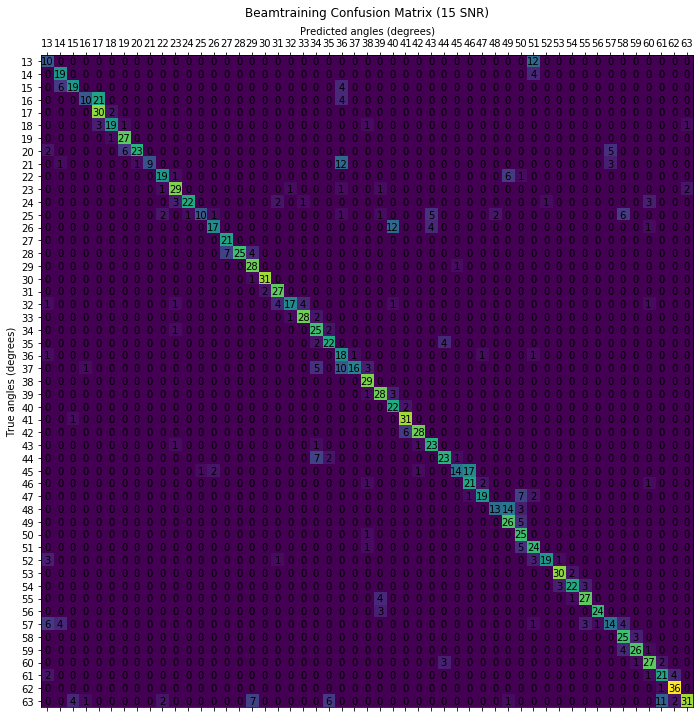

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 1.1597 - sparse_categorical_accuracy: 0.7539
	Test accuracy: 0.75386596


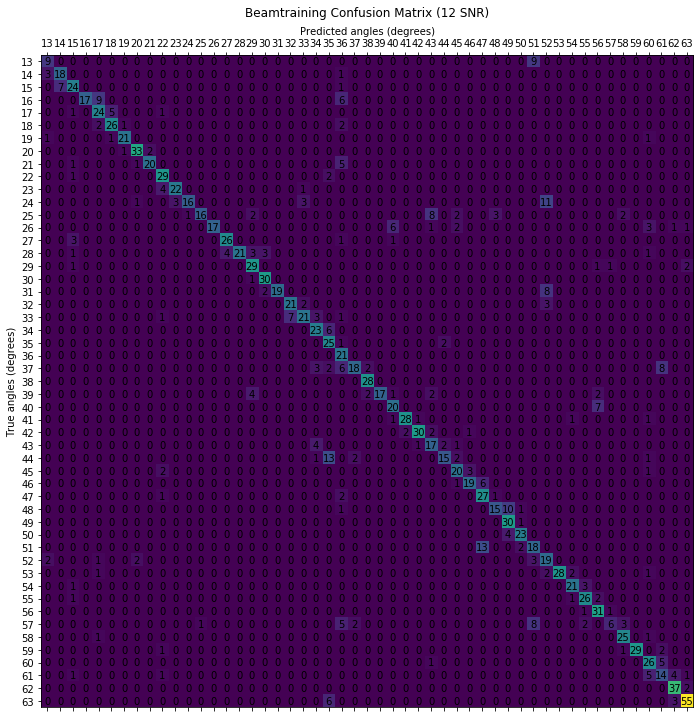

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 1.1913 - sparse_categorical_accuracy: 0.7388
	Test accuracy: 0.738822


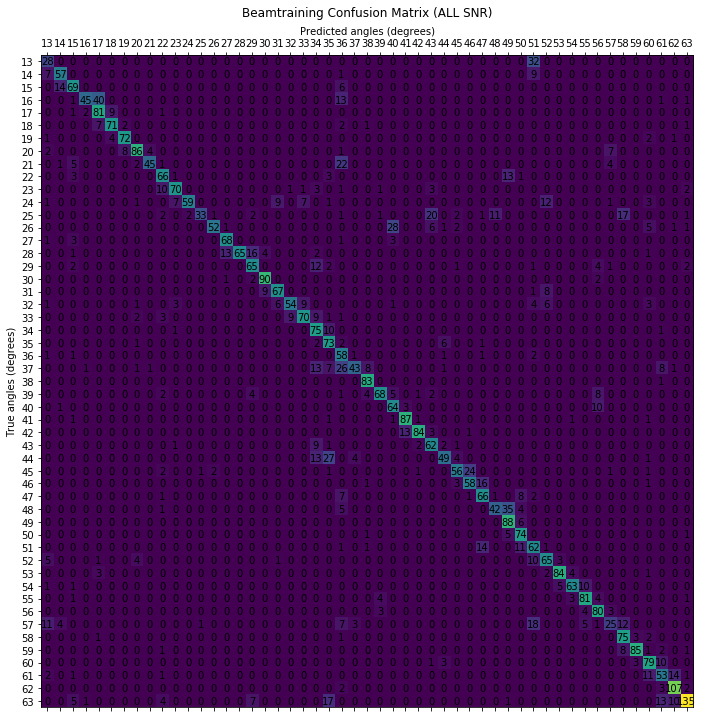


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         1.078342]
 [ 90.        22.07966 ]
 [100.        40.808683]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.552116]
 [ 90.        21.152073]
 [100.        39.942014]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

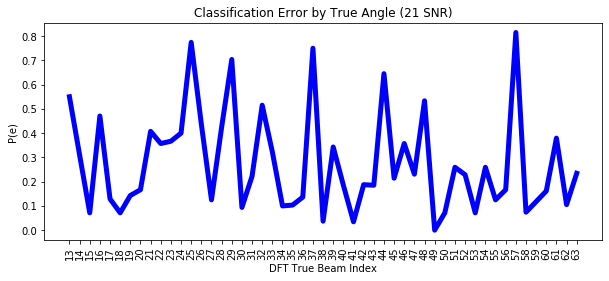

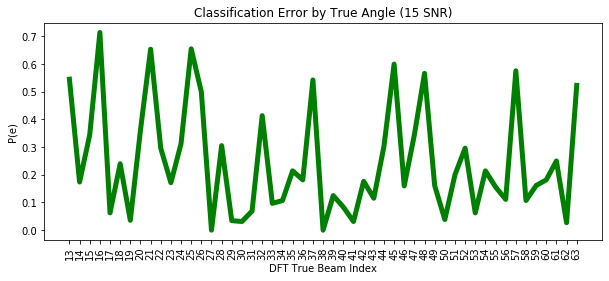

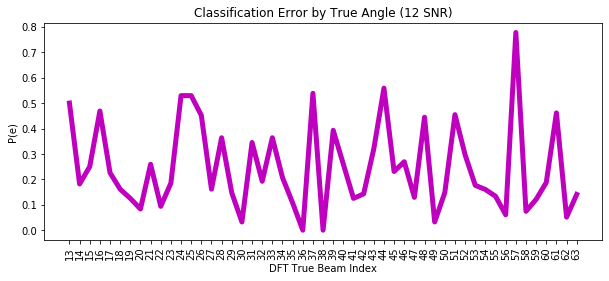

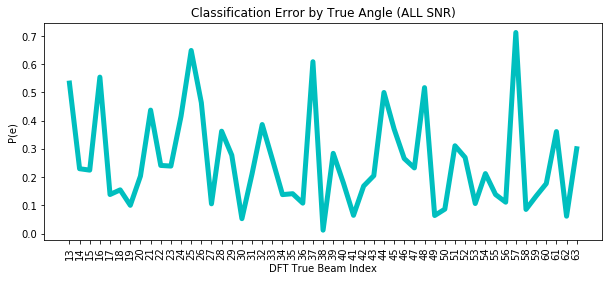

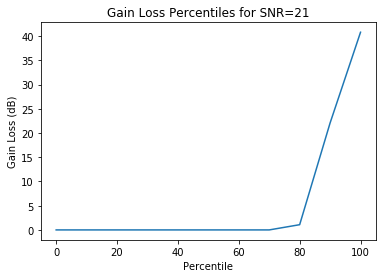

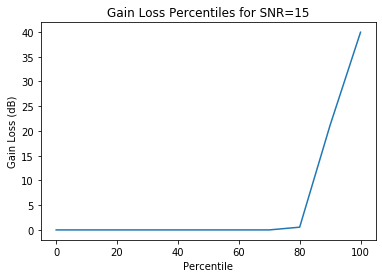

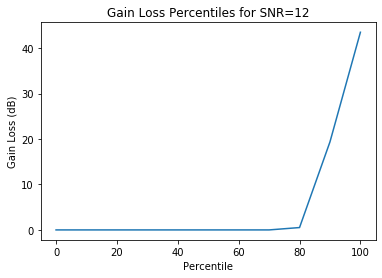

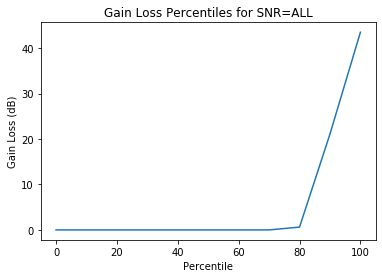

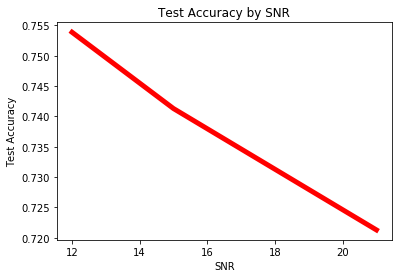

In [148]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 4 Measurements


Training model for PN combo 0...
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_63 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 15,987
Trainable params: 15,603
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

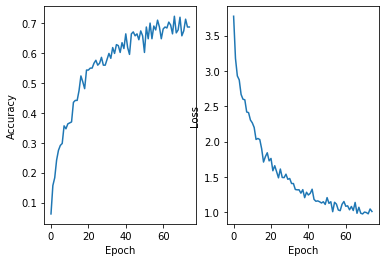

In [151]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 1.4144 - sparse_categorical_accuracy: 0.6348
	Test accuracy: 0.6348387


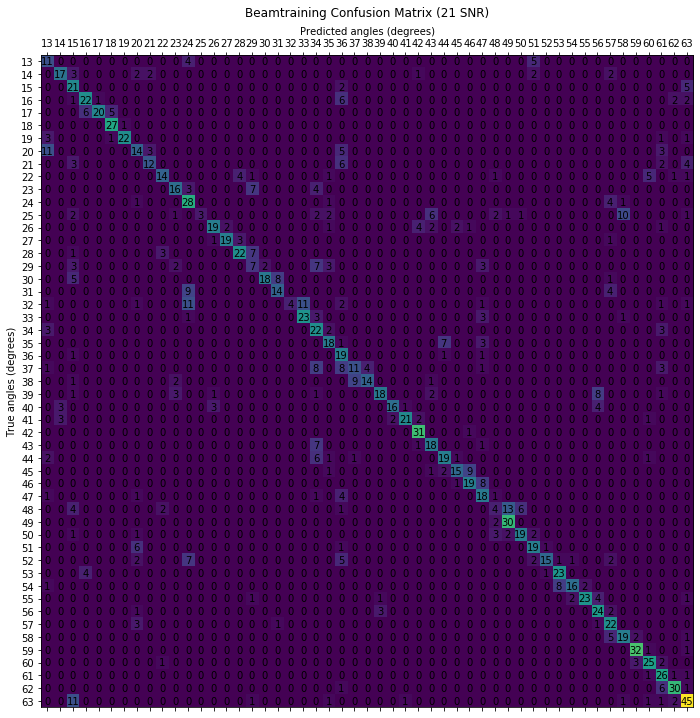

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 1.6824 - sparse_categorical_accuracy: 0.6381
	Test accuracy: 0.6380645


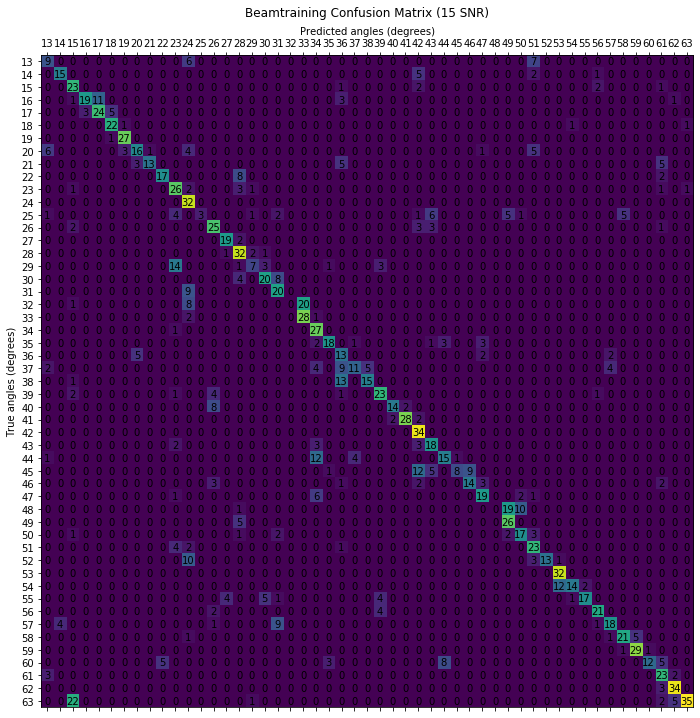

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 1.4314 - sparse_categorical_accuracy: 0.6237
	Test accuracy: 0.62371135


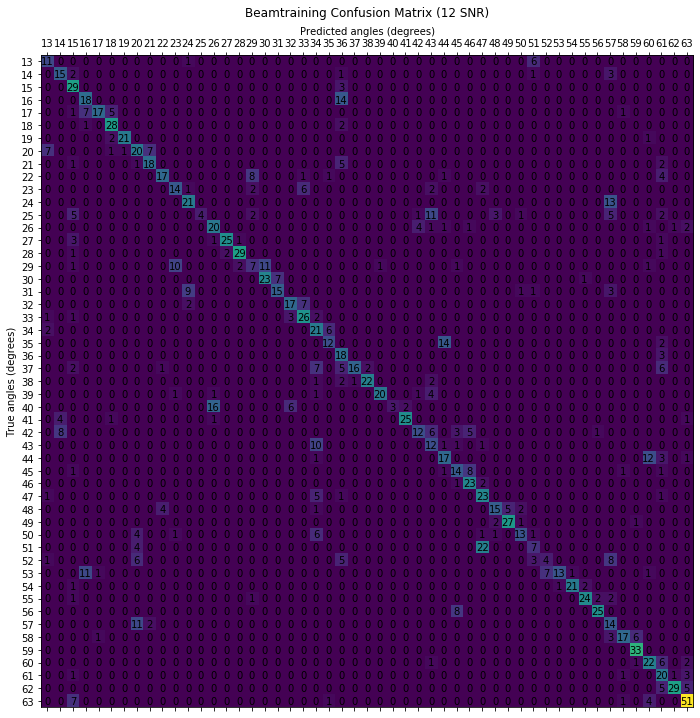

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 1.5094 - sparse_categorical_accuracy: 0.6322
	Test accuracy: 0.6322012


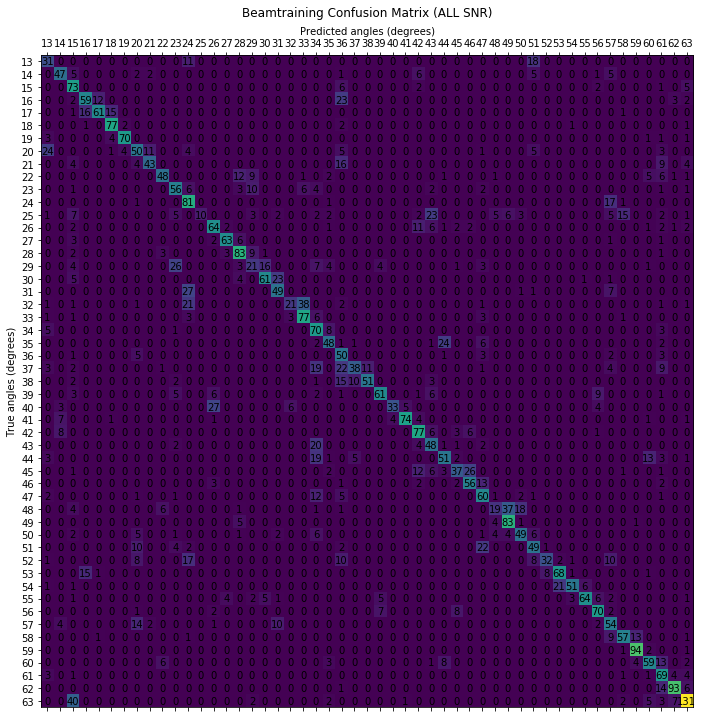


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.941034]
 [ 80.        17.553681]
 [ 90.        26.797469]
 [100.        42.043747]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         1.215855]
 [ 80.        18.517643]
 [ 90.        27.451796]
 [100.        39.577296]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         1.11641

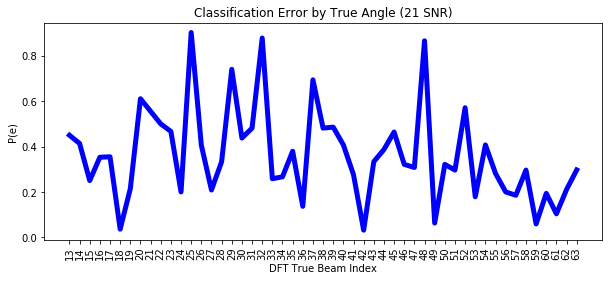

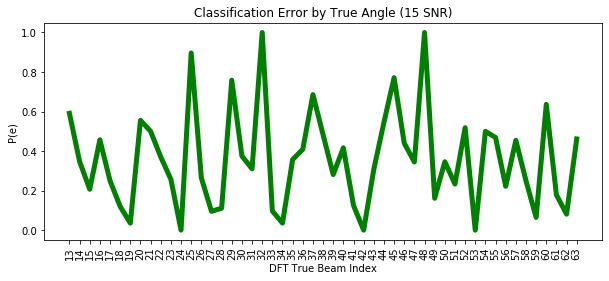

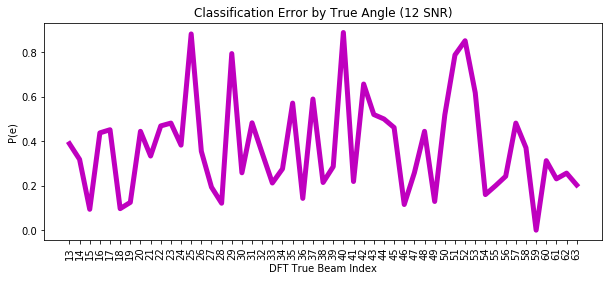

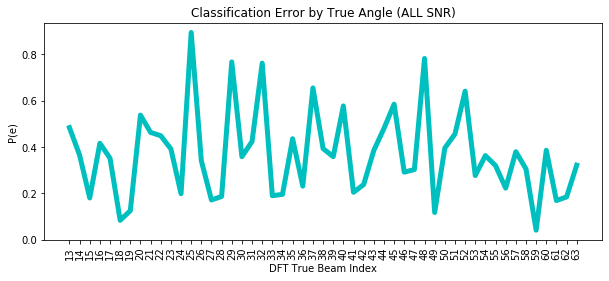

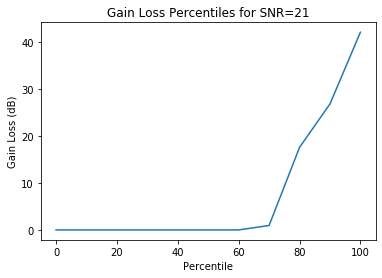

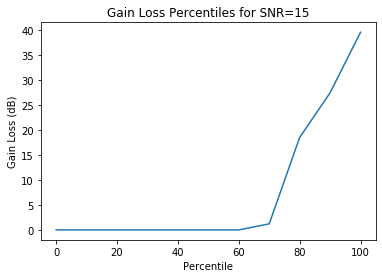

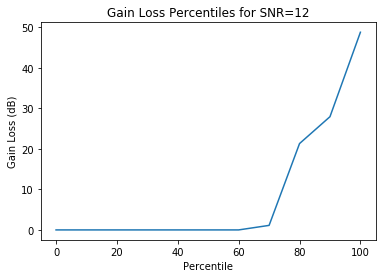

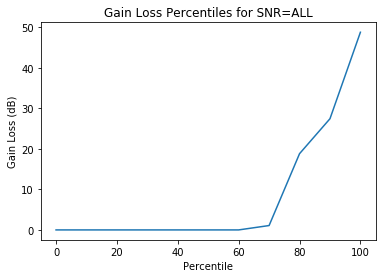

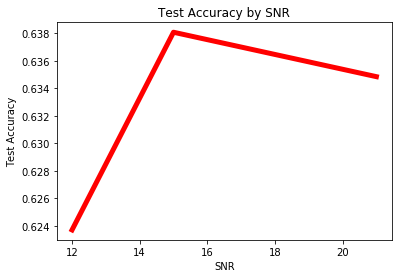

In [152]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 3 Measurements


Training model for PN combo 0...
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_65 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 15,923
Trainable params: 15,539
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

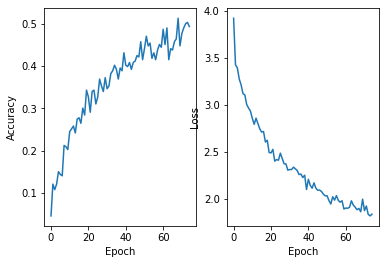

In [155]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 2.1294 - sparse_categorical_accuracy: 0.4361
	Test accuracy: 0.43612903


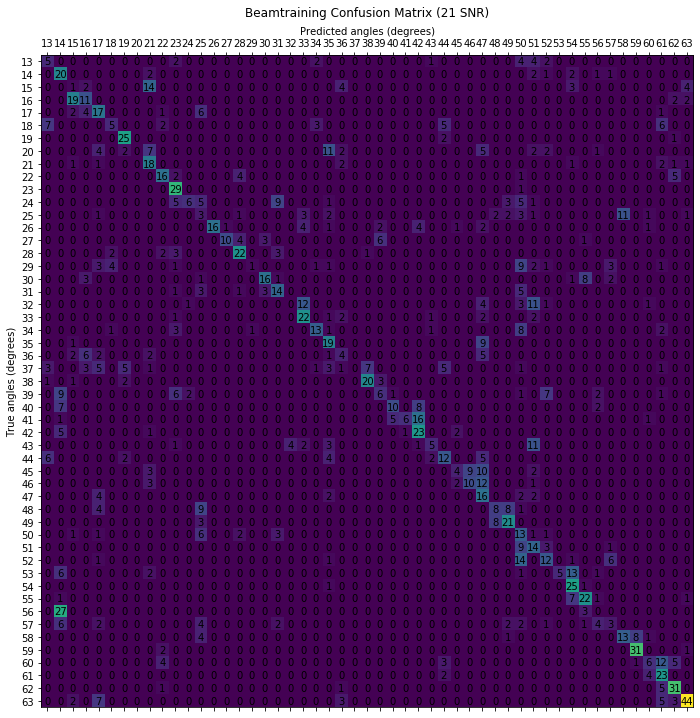

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1550/1550 - 0s - loss: 2.2685 - sparse_categorical_accuracy: 0.4290
	Test accuracy: 0.42903227


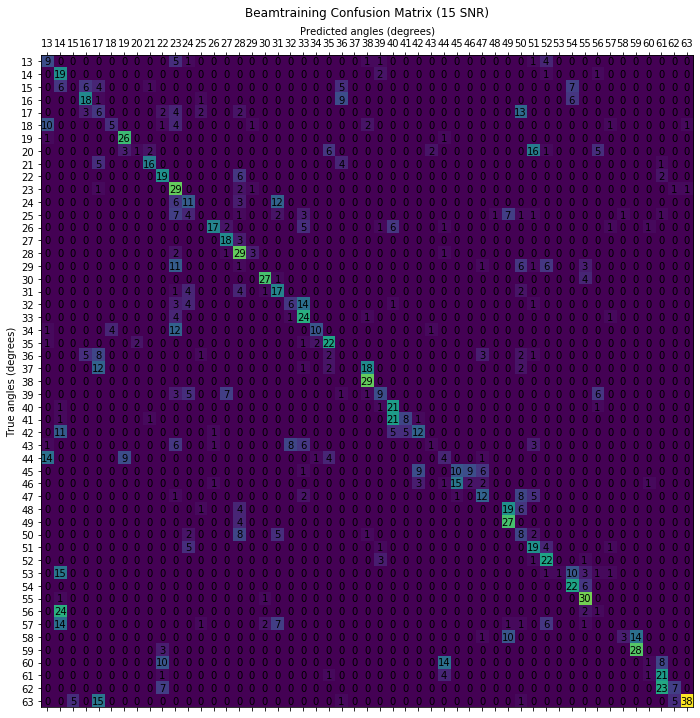

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1552/1552 - 0s - loss: 2.1969 - sparse_categorical_accuracy: 0.3956
	Test accuracy: 0.39561856


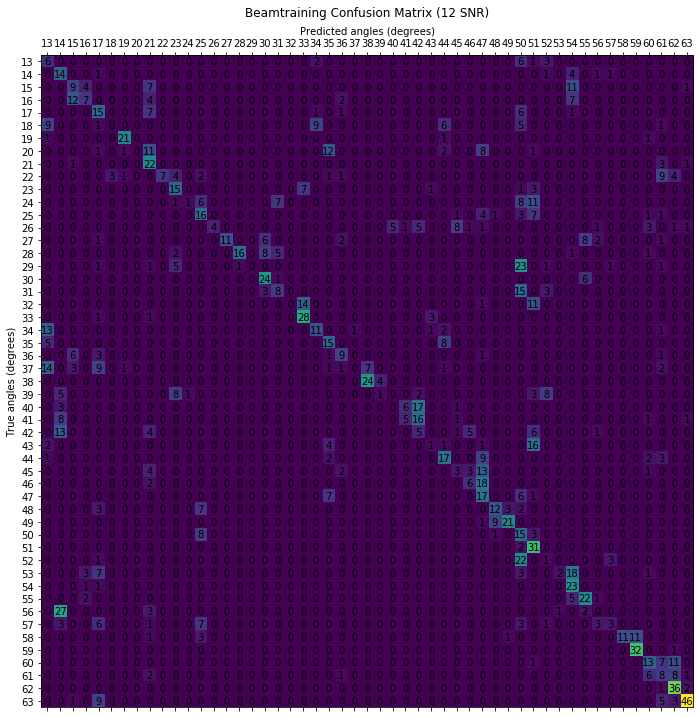

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (0, 50)
4652/4652 - 0s - loss: 2.1983 - sparse_categorical_accuracy: 0.4202
	Test accuracy: 0.42024934


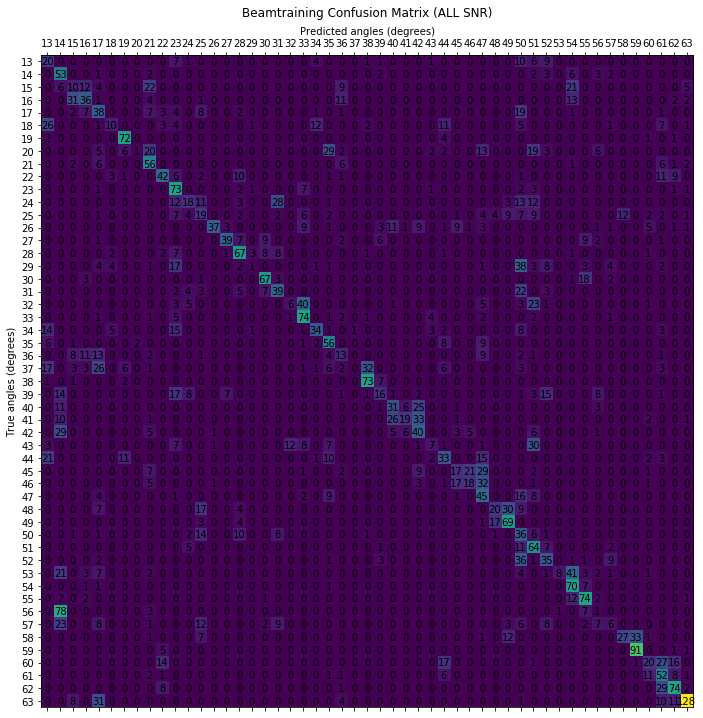


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         1.120288]
 [ 60.        11.380901]
 [ 70.        19.71135 ]
 [ 80.        25.648205]
 [ 90.        34.210534]
 [100.        40.099745]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         1.469688]
 [ 60.        13.321964]
 [ 70.        21.702675]
 [ 80.        27.092745]
 [ 90.        35.496084]
 [100.        39.892257]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         3.534053]
 [ 60.        16.639602]
 [ 70.        24.27269

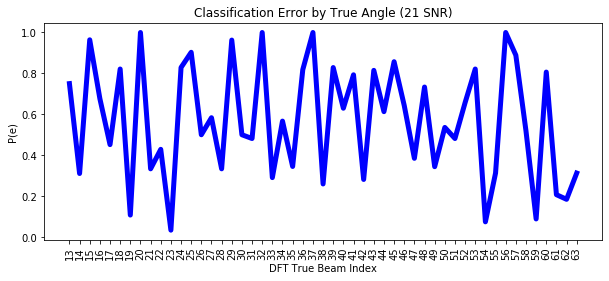

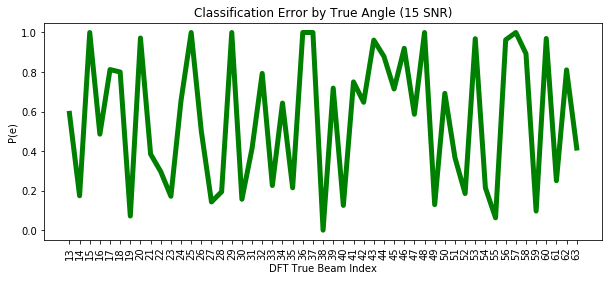

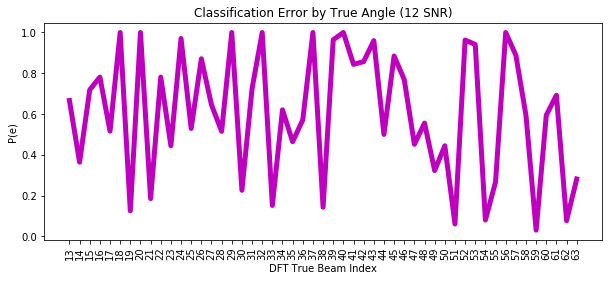

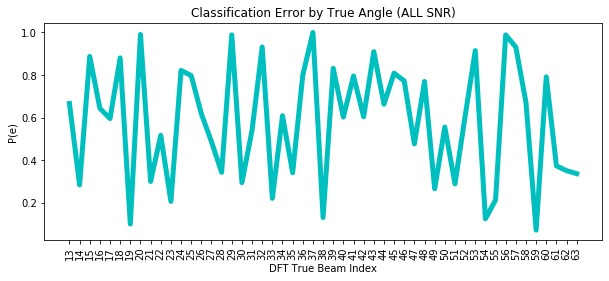

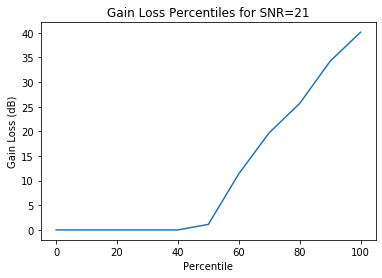

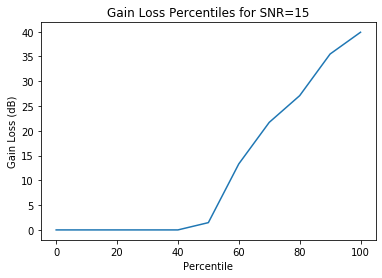

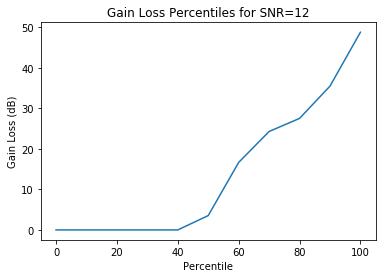

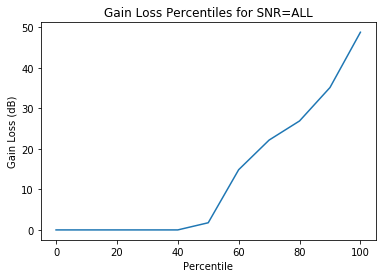

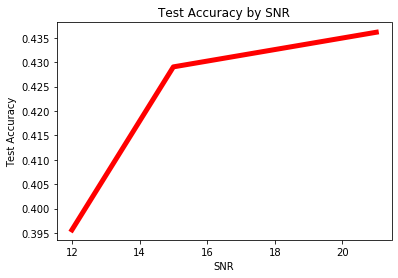

In [156]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 2 Measurements


Training model for PN combo 0...
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
batch_normalization_66 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_67 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 15,859
Trainable params: 15,475
Non-trainable params: 384
__________________

Text(0.5, 0, 'Epoch')

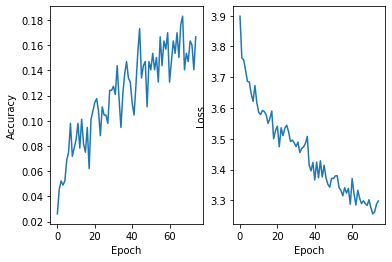

In [159]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (1, 50)
1550/1550 - 0s - loss: 3.4102 - sparse_categorical_accuracy: 0.1929
	Test accuracy: 0.19290322


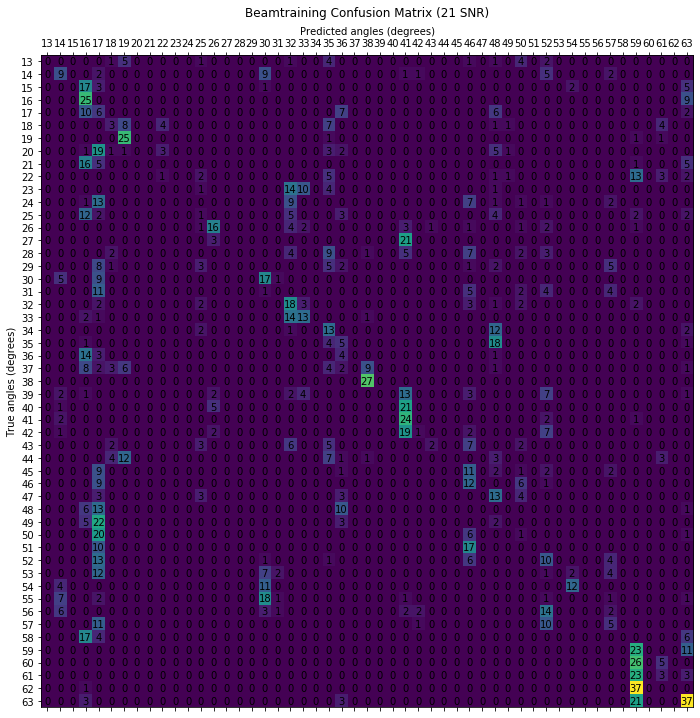

15 dB SNR --
(1550, 51)
	labels:      (0, 50)
	predictions: (1, 50)
1550/1550 - 0s - loss: 5.2909 - sparse_categorical_accuracy: 0.2148
	Test accuracy: 0.21483871


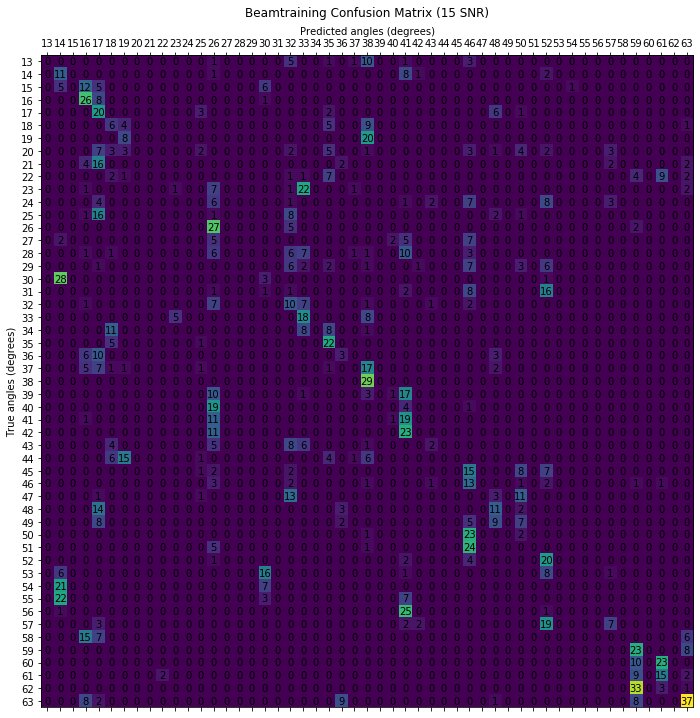

12 dB SNR --
(1552, 51)
	labels:      (0, 50)
	predictions: (1, 50)
1552/1552 - 0s - loss: 3.3054 - sparse_categorical_accuracy: 0.1959
	Test accuracy: 0.19587629


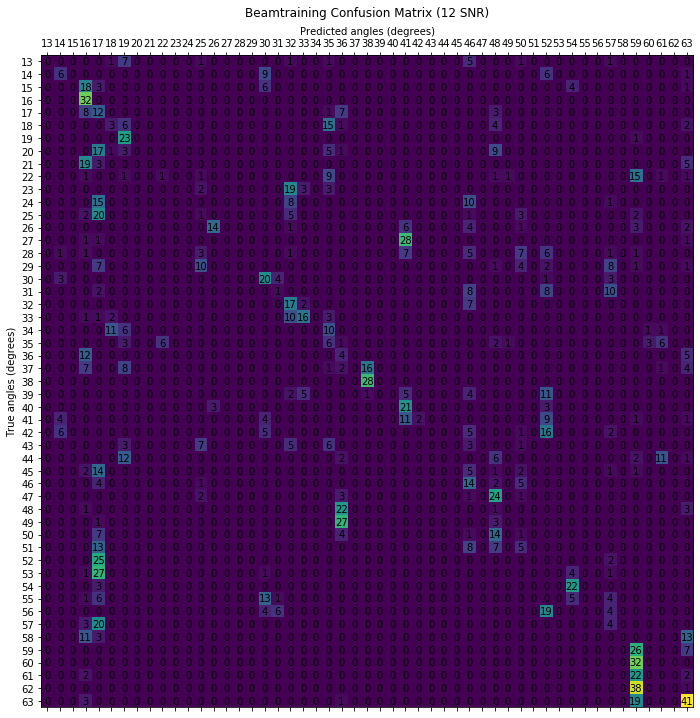

ALL SNR values --
(4652, 51)
	labels:      (0, 50)
	predictions: (1, 50)
4652/4652 - 0s - loss: 4.0019 - sparse_categorical_accuracy: 0.2012
	Test accuracy: 0.20120378


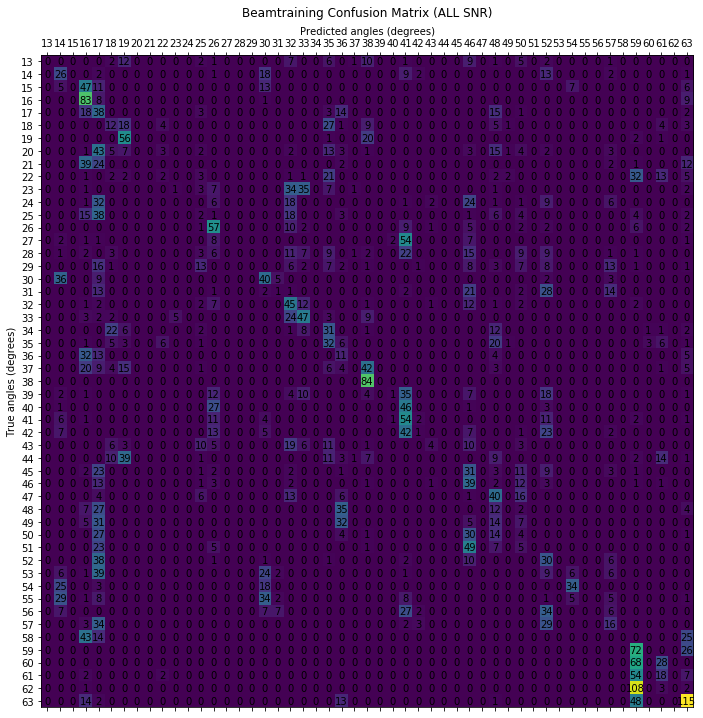


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.144747]
 [ 30.         5.749827]
 [ 40.        14.365812]
 [ 50.        19.147804]
 [ 60.        22.591383]
 [ 70.        25.784409]
 [ 80.        33.364335]
 [ 90.        35.707345]
 [100.        48.104617]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         2.946609]
 [ 40.        14.978859]
 [ 50.        19.654599]
 [ 60.        23.71577 ]
 [ 70.        26.640817]
 [ 80.        29.236343]
 [ 90.        37.421115]
 [100.        39.972557]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         5.342484]
 [ 40.        14.050686]
 [ 50.        18.175999]
 [ 60.        22.730885]
 [ 70.        25.68145

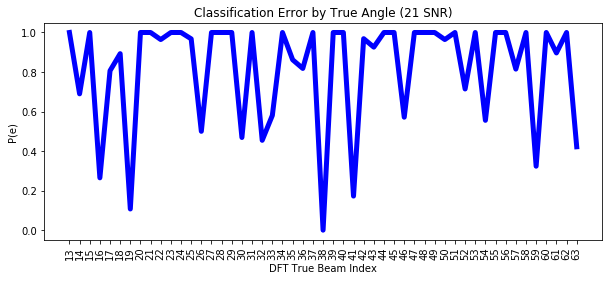

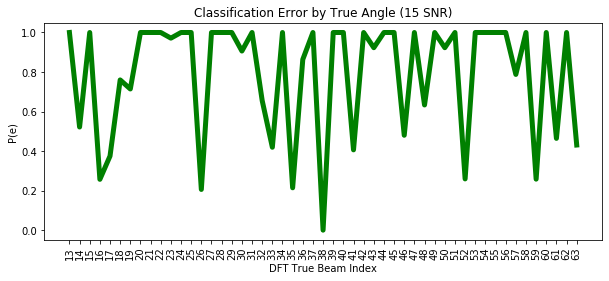

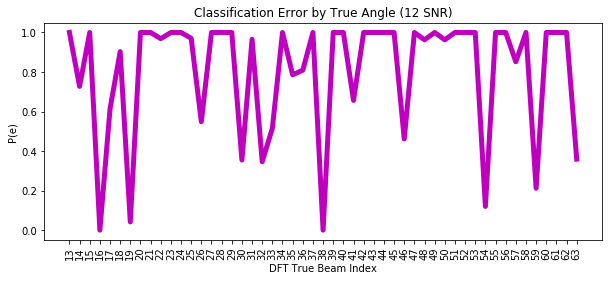

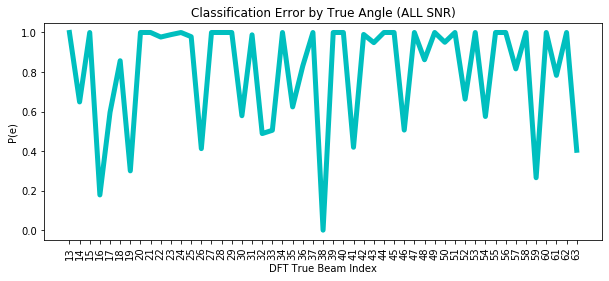

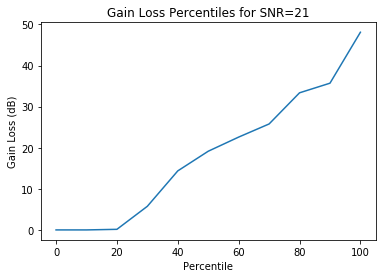

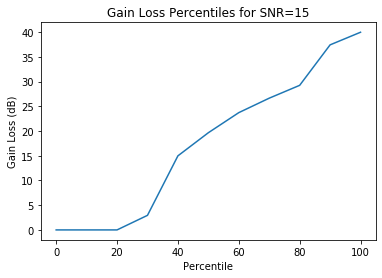

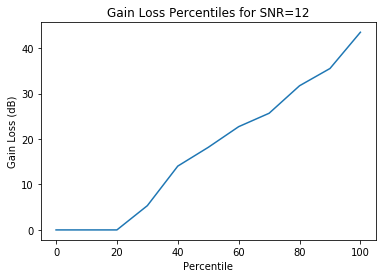

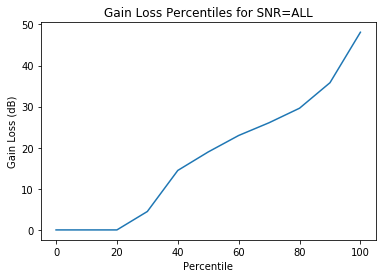

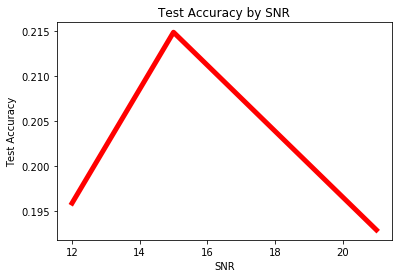

In [160]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")

        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        #plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Overall Performance Curves

In [4]:
# Check that all M values were tested
print(len(all_gainLoss))
print(all_gainLoss.keys())
#print(all_gainLoss[36])
#print(len(GAIN_LOSS_PERCENTILES))

NameError: name 'all_gainLoss' is not defined

In [ ]:
## Save total results to a pickle file
import pickle

## See how many results are available
print(len(all_test_acc))
print(len(all_confusionMat))
print(len(all_pe_byLabel))

print(all_test_acc.keys())
print(all_test_acc[2])

## Save to a pickle file
print(NUM_ANGLES_PER_DFT)
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS SAVED
#TODO: SAVE ALL GAIN LOSS PERCENTILES AND MODELS TO AN OVERALL DICTIONARY
with open('all_NN_results_exp_train{}.pkl'.format(NUM_ANGLES_PER_DFT), 'wb') as f:
    pickle.dump([all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss], f)


#### Plot the training set size results below

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

## Load the pickle file
ALL_NUM_ANGLES_PER_DFT = np.array([2, 5, 10, 15, 20])
print(ALL_NUM_ANGLES_PER_DFT)
#return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS CAPTURED

GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)
combined_test_acc = {}
combined_confusionMat = {}
combined_pe_byLabel = {}
combined_gainLoss = {}

for num_i in ALL_NUM_ANGLES_PER_DFT:
    with open('all_NN_results_exp_train{}rand.pkl'.format(num_i), 'rb') as f:
        combined_test_acc[num_i], combined_confusionMat[num_i], combined_pe_byLabel[num_i], combined_gainLoss[num_i] = pickle.load(f)

[ 2  5 10 15 20]


In [6]:
print(len(combined_gainLoss[2]))
#print(combined_gainLoss[2][4])

print(plot_test_acc_allsnr.shape)
print(plot_gainLoss_perc.shape)


14


NameError: name 'plot_test_acc_allsnr' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 4  5  6  7  8  9 10 12 15 16 20] [[0.63220119 0.66491771 0.69072706 0.         0.        ]
 [0.73882198 0.77128547 0.80189675 0.         0.        ]
 [0.81491834 0.83854043 0.85511065 0.         0.        ]
 [0.82502151 0.84760314 0.87776607 0.         0.        ]
 [0.84329319 0.87383735 0.88145417 0.         0.        ]
 [0.84866726 0.88409251 0.88988411 0.         0.        ]
 [0.85662079 0.87669927 0.89199156 0.         0.        ]
 [0.86070508 0.8824231  0.9004215  0.         0.        ]
 [0.86263973 0.88623899 0.90727079 0.         0.        ]
 [0.85855544 0.88456953 0.90516335 0.         0.        ]
 [0.85296649 0.88719296 0.8946259  0.         0.        ]]
[ 2  5 20]
[[ 0.        0.        0.      ]
 [21.110229 14.88382  12.671733]]


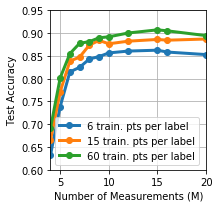

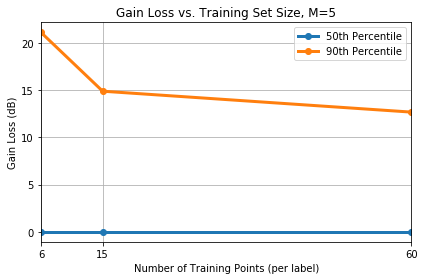

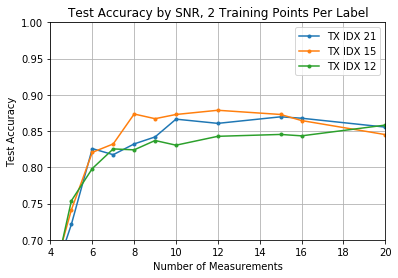

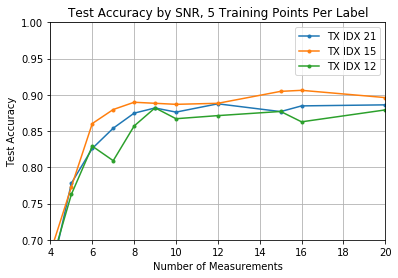

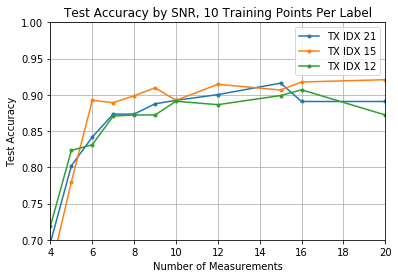

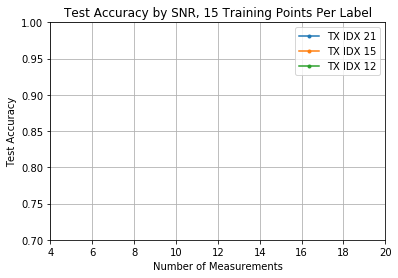

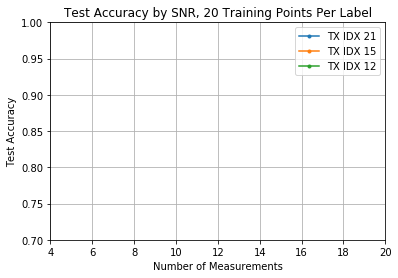

In [22]:
### Plot the overall results for the testing with all SNRs
included_num_meas = np.array([4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 20])
included_num_angles = np.array([2, 5, 20])

plot_test_acc_allsnr = np.zeros((len(ALL_NUM_ANGLES_PER_DFT), len(DATA_SNR)+1, len(included_num_meas)))
# plot_gainLoss_perc = np.zeros((len(ALL_NUM_ANGLES_PER_DFT), len(DATA_SNR)+1, len(included_num_meas), len(GAIN_LOSS_PERCENTILES)))
# plot_test_acc_allsnr = np.zeros((len(included_num_angles), len(DATA_SNR)+1, len(included_num_meas)))
plot_gainLoss_perc = np.zeros((len(included_num_angles), len(DATA_SNR)+1, len(included_num_meas), len(GAIN_LOSS_PERCENTILES)))

# Averaged over all PN beam combos
for num_ind in np.arange(len(included_num_angles)):
    for m_i in np.arange(len(included_num_meas)):
        for snr_ind in np.arange(len(DATA_SNR)+1):
            if snr_ind != len(DATA_SNR):
                SNR_i = DATA_SNR[snr_ind]
            else:
                SNR_i = 'ALL'
            temp_test_acc = combined_test_acc[included_num_angles[num_ind]][included_num_meas[m_i]]
            plot_test_acc_allsnr[num_ind, snr_ind, m_i] = np.mean(temp_test_acc[:, snr_ind])
            plot_gainLoss_perc[num_ind, snr_ind, m_i, :] = combined_gainLoss[included_num_angles[num_ind]][included_num_meas[m_i]][snr_ind, 0, :]

# Plot the result
# Plot of accuracy testing all SNRs together
fig = plt.figure()
fig.set_size_inches(6, 2.25)
plt.plot(included_num_meas, plot_test_acc_allsnr[:, len(DATA_SNR), :].T, marker="o", lw=3)
#plt.title("Test Accuracy vs Number of Measurements (M)")
plt.xlabel("Number of Measurements (M)")
plt.ylabel("Test Accuracy")
plt.legend(("{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[0]*3), \
            "{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[1]*3), \
            #"{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[2]*3), \
            #"{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[3]*3), \
            "{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[4]*3)
           ))
plt.grid(True)
plt.ylim(0.6, 0.95)
plt.yticks(np.arange(60, 100, 5)/100)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
plt.tight_layout()
plt.savefig("../figures/nn_acc_allSNR_exp_train{}.png".format("ALL"))
plt.savefig("../figures/nn_acc_allSNR_exp_train{}.eps".format("ALL"))

fig.set_size_inches(3.15, 3)
plt.legend(("{} train. pts per label".format(ALL_NUM_ANGLES_PER_DFT[0]*3), \
            "{} train. pts per label".format(ALL_NUM_ANGLES_PER_DFT[1]*3), \
            #"{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[2]*3), \
            #"{} training pts per label".format(ALL_NUM_ANGLES_PER_DFT[3]*3), \
            "{} train. pts per label".format(ALL_NUM_ANGLES_PER_DFT[4]*3)
           ))
plt.xlim(np.min(included_num_meas),int(20))
plt.tight_layout()
plt.savefig("../figures/nn_acc_allSNR_exp_train{}_s2.eps".format("ALL"))
print(included_num_meas, plot_test_acc_allsnr[:, len(DATA_SNR), :].T)


# Plot of gain loss vs number of measurements (with all plotted training set sizes)
gainLoss_num_ind = 1;
gainLoss_perc_ind = [5, 9];
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(included_num_angles, plot_gainLoss_perc[:, len(DATA_SNR), gainLoss_num_ind, gainLoss_perc_ind], marker="o", lw=3)
plt.title("Gain Loss vs. Training Set Size, M={}".format(included_num_meas[gainLoss_num_ind]))
plt.xlabel("Number of Training Points (per label)")
plt.ylabel("Gain Loss (dB)")
plt.legend(("50th Percentile", "90th Percentile"))
plt.grid(True)
# plt.ylim(0.6, 1)
# plt.yticks(np.arange(60, 105, 5)/100)
plt.xlim(np.min(included_num_angles),np.max(included_num_angles))
plt.xticks(included_num_angles, included_num_angles*3)
plt.tight_layout()
plt.savefig("../figures/nn_gLoss_allSNR_exp_trainM{}.png".format(included_num_meas[gainLoss_num_ind]))

print(included_num_angles)
print(plot_gainLoss_perc[:, len(DATA_SNR), gainLoss_num_ind, gainLoss_perc_ind].T)

# Plot of accuracy vs each SNR
for num_ind in np.arange(len(ALL_NUM_ANGLES_PER_DFT)):
    plt.figure()
    plt.plot(included_num_meas, plot_test_acc_allsnr[num_ind, np.arange(len(DATA_SNR)), :].T, marker=".")
    plt.title("Test Accuracy by SNR, {} Training Points Per Label".format(ALL_NUM_ANGLES_PER_DFT[num_ind]))
    plt.xlabel("Number of Measurements")
    plt.ylabel("Test Accuracy")
    plt.legend(("TX IDX {}".format(DATA_SNR[0]), "TX IDX {}".format(DATA_SNR[1]), "TX IDX {}".format(DATA_SNR[2])))
    plt.grid(True)
    plt.ylim(0.7, 1)
    plt.xlim(np.min(included_num_meas),np.max(included_num_meas))

(-15, 30)

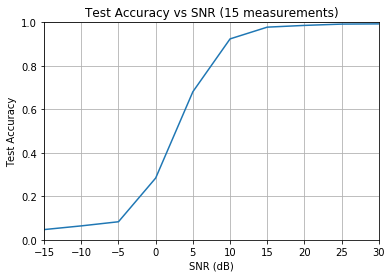

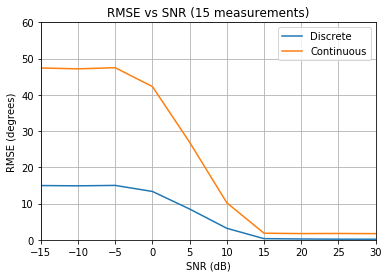

In [101]:
### Plot the overall results (i.e. anything stored in the dictionaries) ###

# Convert the dictionaries (for plotable metrics) into arrays
nSNR = len(SNR)
class_test_acc_arr = np.zeros(len(SNR), 2)
for iSNR in np.arange(nSNR):
    class_test_acc_arr[iSNR, 0] = SNR[iSNR]
    class_test_acc_arr[iSNR, 1] = class_test_acc[SNR[iSNR]]

# Store the results
all_test_acc[NUM_MEAS] = class_test_acc
all_confusionMat[NUM_MEAS] = class_confusionMat
all_RMSE_disc[NUM_MEAS] = class_RMSE_disc
all_RMSE_cont[NUM_MEAS] = class_RMSE_cont

# Plot of accuracy vs. SNR
plt.figure()
plt.plot(SNR, list(class_test_acc.values()))
plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(class_RMSE_disc.values()))
plt.plot(SNR, list(class_RMSE_cont.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.legend(("Discrete", "Continuous"))
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)


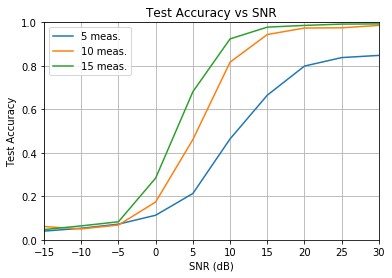

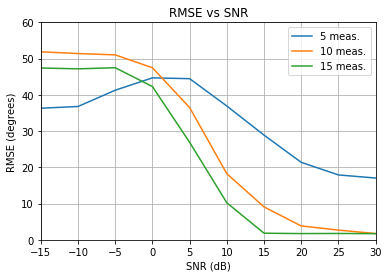

In [103]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_test_acc.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
plt.title("Test Accuracy vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_cont[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_rmse.png')


In [104]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
    all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
    all_rmse_cont_np = np.array(list(all_RMSE_cont[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="Accuracy_{}".format(label_plots[i]),
                        value=all_test_acc_np)
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_cont_np)

print(all_test_res)
all_test_res.to_csv("../data/classification_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.  Accuracy_15 meas.  \
-15     36.307964      51.869648      47.408928              0.047   
-10     36.784466      51.398037      47.175220              0.064   
-5      41.275127      51.028347      47.482777              0.083   
 0      44.687183      47.476574      42.285374              0.284   
 5      44.462864      36.485699      26.908812              0.681   
 10     36.920204      18.239145      10.213766              0.924   
 15     28.888153       9.073179       1.818401              0.978   
 20     21.375340       3.823220       1.717062              0.986   
 25     17.899832       2.673465       1.744454              0.992   
 30     17.044321       1.730174       1.695887              0.993   

     Accuracy_10 meas.  Accuracy_5 meas.  
-15              0.061             0.040  
-10              0.050             0.053  
-5               0.068             0.072  
 0     

# Regression Method - Continuous Angle Prediction
For data communication, a true angle prediction might be better than a discrete classification.  Classification heavily penalizes wrongly classifying to neighboring beams, even if the angle is almost exactly in between the two beam angles.  This may not be realistic for real-world implementations, as the actual beam may have significantly more angular control and thus could steer to the exact direction between the training beams.  Even without the ability to steer in any direction, classifying to neighboring beams should intuitively be better than classifying to further beams.

In [41]:
### Variable reorganization for regression (add another dimension) ###

# ALL DATA/LABEL/ANGLE VARIABLES FOR REGRESSION ARE LABELED AS "*_r" (where * is the original name used for classification)
USING_CNN_ARG = False

## Storage dictionaries/running variables for regression
train_data_dict_r = {}
test_data_dict_r = {}
val_data_dict_r = {}
train_angles_dict_r = {}
test_angles_dict_r = {}
val_angles_dict_r = {}
train_labels_dict_r = {}
test_labels_dict_r = {}
val_labels_dict_r = {}

# For the regression method with CNNs, need dimensions to be N x D x 1 (instead of N x D or D x N)
print("Modifying training/validation/testing datasets:")
for snr_i in np.arange(len(train_data_dict)):
    if USING_CNN_ARG:
        train_data_dict_r[SNR[snr_i]] = np.array([train_data_dict[SNR[snr_i]].T]).T
        train_labels_dict_r[SNR[snr_i]] = np.array([train_labels_dict[SNR[snr_i]].T]).T
        train_angles_dict_r[SNR[snr_i]] = np.array([train_angles_dict[SNR[snr_i]].T]).T

        val_data_dict_r[SNR[snr_i]] = np.array([val_data_dict[SNR[snr_i]].T]).T
        val_labels_dict_r[SNR[snr_i]] = np.array([val_labels_dict[SNR[snr_i]].T]).T
        val_angles_dict_r[SNR[snr_i]] = np.array([val_angles_dict[SNR[snr_i]].T]).T

        test_data_dict_r[SNR[snr_i]] = np.array([test_data_dict[SNR[snr_i]].T]).T
        test_labels_dict_r[SNR[snr_i]] = np.array([test_labels_dict[SNR[snr_i]].T]).T
        test_angles_dict_r[SNR[snr_i]] = np.array([test_angles_dict[SNR[snr_i]].T]).T
    
    else:
        train_data_dict_r[SNR[snr_i]] = train_data_dict[SNR[snr_i]]
        train_labels_dict_r[SNR[snr_i]] = train_labels_dict[SNR[snr_i]]
        train_angles_dict_r[SNR[snr_i]] = train_angles_dict[SNR[snr_i]]

        val_data_dict_r[SNR[snr_i]] = val_data_dict[SNR[snr_i]]
        val_labels_dict_r[SNR[snr_i]] = val_labels_dict[SNR[snr_i]]
        val_angles_dict_r[SNR[snr_i]] = val_angles_dict[SNR[snr_i]]

        test_data_dict_r[SNR[snr_i]] = test_data_dict[SNR[snr_i]]
        test_labels_dict_r[SNR[snr_i]] = test_labels_dict[SNR[snr_i]]
        test_angles_dict_r[SNR[snr_i]] = test_angles_dict[SNR[snr_i]]

    print("\ttrain: {}, val: {}, test: {}".format(train_data_dict_r[SNR[snr_i]].shape, 
                                                  val_data_dict_r[SNR[snr_i]].shape,
                                                  test_data_dict_r[SNR[snr_i]].shape))

# Need to reshape the overall training and validation sets too
if USING_CNN_ARG:
    train_data_all_r = np.array([train_data_all.T]).T
    val_data_all_r = np.array([val_data_all.T]).T
    train_angles_all_r = np.array([train_angles_all.T]).T
    val_angles_all_r = np.array([val_angles_all.T]).T
else:
    train_data_all_r = train_data_all
    val_data_all_r = val_data_all
    train_angles_all_r = train_angles_all
    val_angles_all_r = val_angles_all

print("Total training dataset size:   {}".format(train_data_all_r.shape))
print("Total validation dataset size: {}".format(val_data_all_r.shape))

Modifying training/validation/testing datasets:
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
Total training dataset size:   (70000, 15)
Total validation dataset size: (20000, 15)


In [28]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
# Keys: Number of measurements used (i.e. 5, 10, or 15)
all_RMSE_reg = {}
all_acc_reg = {} # TODO


In [42]:
### Dictionaries to hold metrics for different runs ###
# Keys: SNR value
RMSE_reg = {}
acc_reg = {} # TODO


In [43]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Produces the best results - MAE = 17.6 (@10 measurements, 5dB SNR - still really high)

inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
#x = layers.Dense(64, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


## CNN architecture
# 1D convolutions with maxpooling
# batch norm to reduce initialization dependence

# model = keras.Sequential()

# model.add(layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(NUM_MEAS, 1)))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.Flatten())

# # model.add(layers.Dense(64, input_dim=NUM_MEAS))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# # #model.add(Dropout(0.5))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))

# model.add(layers.Dense(1))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #RMSprop(0.01), # # Optimizer
              # Loss function to minimize
              loss='mse',       # mean squared error
              # List of metrics to monitor
              metrics=['mae', 'mse'])  # mean absolute error

model.summary()

model.fit(train_data_all_r, train_angles_all_r, epochs=3, batch_size=NUM_MEAS,
          validation_data=(val_data_all_r, val_angles_all_r))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 20000 samples
Epoch 1/3
70000/70000 [==============================] - 9s 134us/sample - loss: 667.1582 - mae: 19.6238 - mse: 667.1575 - val_loss: 601.4920 - val_mae: 17.7873 - val_mse: 601.4926
Epoch 2/3
70000/70000 [=


-15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 147.5195 - mae: 9.2804 - mse: 117.7993
	Test MSE: 117.79928
	Keras RMSE:  33.889206

-10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 130.0401 - mae: 9.6180 - mse: 132.8101
	Test MSE: 132.81007
	Keras RMSE:  35.85139

-5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 135.0462 - mae: 10.6879 - mse: 175.1465
	Test MSE: 175.14647
	Keras RMSE:  35.018875

0 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 225.8660 - mae: 13.5185 - mse: 286.8965
	Test MSE: 286.89655
	Keras RMSE:  32.322292

5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 268.4444 - mae: 16.6299 - mse: 445.8639
	Test MSE: 445.86386
	Keras RMSE:  23.98994

10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 846.7432 - mae: 21.8476 - mse: 725.3643
	Test MSE: 725.36426
	Keras RMSE:  13.325187

15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1321.6547 - mae: 24.2567 - mse: 841.4233
	Test MSE: 841.42334
	Keras RMSE:  7.92558

20 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1008.9638 - mae: 25.7860 - mse: 919.3963
	Test MSE: 919.39

(-15, 30)

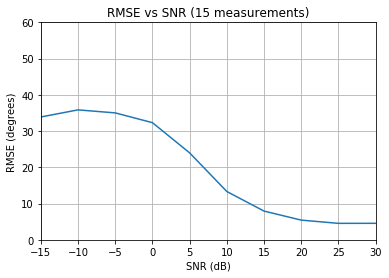

In [44]:
### Test the NN Model ###

for SNR_i in SNR:
    print("\n{} dB SNR --".format(SNR_i))
    test_pred_angles = model.predict(test_data_dict_r[SNR_i])
    print(test_pred_angles.shape)

    test_loss, test_mae, test_mse = model.evaluate(test_data_dict_r[SNR_i],  test_labels_dict_r[SNR_i], verbose=2)
    print('\tTest MSE:', test_mse)
    
    ## Compute the RMSE of the angles
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(test_angles_dict_r[SNR_i], test_pred_angles)
    rmse_keras = m.result().numpy()
    print('\tKeras RMSE: ', rmse_keras)
    
    RMSE_reg[SNR_i] = rmse_keras

    # Compute the predicted labels and the confusion matrix
#     test_pred_labels = np.argmax(test_predictions, 1)
#     test_confusion = tf.math.confusion_matrix(test_labels_dict[SNR_i],
#                                               test_pred_labels)
#     print(test_confusion)
#     class_confusionMat[SNR_i] = test_confusion

    ## Plot the confusion matrix (see which beams get associated with each other)
#     fig, ax = plt.subplots()
#     ax.matshow(test_confusion)
#     for (i, j), z in np.ndenumerate(test_confusion):
#         ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

#     ax.set_xticklabels(CLASSES)
#     ax.set_yticklabels(CLASSES)
#     ax.xaxis.set_label_position("top")
#     fig.set_size_inches(12, 12)
#     plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
#     plt.xlabel("Predicted angles (degrees)")
#     plt.ylabel("True angles (degrees)")
#     plt.xticks(np.arange(NUM_CLASSES))
#     plt.yticks(np.arange(NUM_CLASSES))
#     plt.savefig('../figures/confusionMatrix_reg_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
#     plt.show()

print("Number of results: {}".format(len(RMSE_reg)))

# Store the results
#all_test_acc[NUM_MEAS] = class_test_acc
all_RMSE_reg[NUM_MEAS] = RMSE_reg

# Plot of accuracy vs. SNR
# plt.figure()
# plt.plot(SNR, list(class_test_acc.values()))
# plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(RMSE_reg.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)

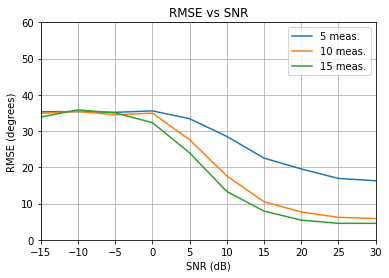

In [45]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_RMSE_reg.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
# plt.figure()
# for i in np.arange(NUM_PLOTS):
#     plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
# plt.title("Test Accuracy vs SNR")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)
# plt.legend(label_plots)
# plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_reg[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_reg_rmse.png')


In [46]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
#     all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
#     all_test_res.insert(loc=int(i), 
#                         column="Accuracy_{}".format(label_plots[i]),
#                         value=all_test_acc_np)
    all_rmse_reg_np = np.array(list(all_RMSE_reg[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_reg_np)

print(all_test_res)
all_test_res.to_csv("../data/regression_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.
-15     35.328289      34.888290      33.889206
-10     35.379852      35.416080      35.851391
-5      35.181820      34.488541      35.018875
 0      35.573147      34.953278      32.322292
 5      33.409790      27.597979      23.989941
 10     28.529898      17.621866      13.325187
 15     22.547327      10.511057       7.925580
 20     19.561069       7.668045       5.431944
 25     16.929165       6.201704       4.540309
 30     16.294001       5.887393       4.549653
